# Сборный проект: восстановление золота
---
Компания разрабатывает решения для эффективной работы промышленных предприятий.

Цель - обучить модель Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

План наших действий будет таким:

1. Изучить и подготовить данные.
2. Провести исследовательский анализ данных.
3. Построить и обучить модель.

---

## 1. Первичное изучение данных. Предобработка.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from toads import *

import warnings

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

Сразу переведём даты в формат `datetime` и сделаем их индексами датафреймов.

In [2]:
train, test, full = [pd.read_csv(f'../../../gold/datasets/gold_recovery_{name}.csv', parse_dates=True, index_col='date')
                     for name in ['train', 'test', 'full']]
dfs = train, test, full

In [3]:
print_shapes(*dfs)

(16860, 86)
(5856, 52)
(22716, 86)


В тестовой выборке присутствуют **не все столбцы**.

Проверим, в каком соотношении разделены выборки.

In [4]:
len(train) / len(full), len(test) / len(full)

(0.7422081352350766, 0.2577918647649234)

Получилось примерно *3:1*.

Сразу обозначим, какие признаки для нас будут целевыми.

In [5]:
# Запишем названия столбцов в переменные
y_rougher = 'rougher.output.recovery'
y_final = 'final.output.recovery'

# Обозначим списком
targets = [y_final, y_rougher]

Теперь перейдём к изучению датасетов.

---

### Обучающая выборка
В обучающей выборке содержится сразу два целевых признака, относящихся к **двум последовательным этапам** - это наталкивает нас на мысль, что выборку нужно будет **разделить** на две отдельных после того, как мы её предобработаем. Потому что мы не можем обучить модель на данных, которые находятся в будущем.

In [6]:
train.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

- Как видим, даты правильно прочитались при открытии датафреймов.
- Отсутствуют категориальные признаки.
- Признаки названы понятно и соответствуют этапам обработки - это упрощает понимание процесса.
- Присутствуют пропуски в большинстве столбцов.
- В названиях признаков существуют подсказки относительно того, влияем мы на этот признак прямым образом или нет. В частности, мы имеем в виду признаки с типом `state` и `calculation`. Это производные признаки, управляемые извне, поэтому мы рассмотрим возможность их **удаления**, если они не понадобятся нам в дальнейшем. Сюда же можно отнести признаки с типом `output`.
- Флотационные установки имеют различные номера и, насколько мы можем сделать вывод по названиям признаков, задействованы в различных процессах.
- Нас смущают пропуски в столбцах с целевым признаком. На таких данных не получится обучить модель. Вряд ли есть смысл спасать эти данные, учитывая, что расчёт может быть затруднён пропусками в других столбцах.

Поскольку у нас достаточно много данных, мы не пожалеем и удалим строки, где есть пропуски.

In [8]:
train.dropna(inplace=True)

In [9]:
train.shape

(11017, 86)

Не так страшно потерять данные, как испортить их излишними стараниями.

#### Формула расчёта эффективности восстановления
Нам нужно проверить, верно ли посчитана эффективность флотации. Для расчёта эффективности воспользуемся данной нам формулой.

In [10]:
def recovery(row, concentrate: str, feed: str, tail: str) -> float:
    """Принимает строку датафрейма, названия признаков и считает эффективность восстановления."""
    concentrate = row[concentrate]
    feed = row[feed]
    tail = row[tail]
    rec = (concentrate * (feed - tail)) / (feed * (concentrate - tail))
    return 0 if np.isnan(rec) else rec

In [11]:
from functools import partial

In [12]:
# Настроим функцию для расчёта эффективности флотации золота
rougher_recovery = partial(recovery, concentrate='rougher.output.concentrate_au', feed='rougher.input.feed_au', tail='rougher.output.tail_au')

In [13]:
# Посчитаем эффективность
float_recovery_calc = train.apply(rougher_recovery, axis=1)
float_recovery_calc.head()

date
2016-01-15 00:00:00    0.871078
2016-01-15 01:00:00    0.868433
2016-01-15 02:00:00    0.868423
2016-01-15 03:00:00    0.872264
2016-01-15 04:00:00    0.866888
dtype: float64

Сравним наши вычисления с имеющимися данными.

In [14]:
from sklearn.metrics import mean_absolute_error as mae

In [15]:
mae(train[y_rougher], float_recovery_calc)

81.91446957640534

Странно, почему такая огромная ошибка для величины, по логике имеющей диапазон от 0 до 1. Посмотрим на целевой признак.

In [16]:
train[y_rougher].describe()

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64

Очевидно, проблема в масштабе признака. А что с конечной эффективностью?

In [17]:
train[y_final].describe()

count    11017.000000
mean        66.808219
std          8.821074
min          0.000000
25%         62.955190
50%         67.319742
75%         72.060933
max        100.000000
Name: final.output.recovery, dtype: float64

То же самое. Приведём целевые признаки к масштабу от 0 до 1.

In [18]:
# Поделим на 100
train.loc[:, targets] /= 100

In [19]:
train[targets].describe()

,final.output.recovery,rougher.output.recovery
count,11017.000000,11017.000000
mean,0.668082,0.827419
std,0.088211,0.135905
min,0.000000,0.000000
25%,0.629552,0.799975
50%,0.673197,0.848478
75%,0.720609,0.896351
max,1.000000,1.000000


Теперь целевые признаки лучше отражают понятие "доля". Посмотрим, насколько точны расчёты теперь.

In [20]:
mae(train[y_rougher], float_recovery_calc)

1.0599401350165123e-16

Превосходная точность. Будем считать, что значениям целевого признака можно доверять.

Заодно проверим точность расчётов конечной эффективности.

In [21]:
# Подставим в формулу нужные признаки для конечного результата
final_recovery = partial(recovery, concentrate='final.output.concentrate_au', feed='rougher.input.feed_au', tail='final.output.tail_au')

In [22]:
final_rec_calc = train.apply(final_recovery, axis=1)

In [23]:
mae(final_rec_calc, train[y_final])

9.14193130947015e-17

Точность ещё ближе к нашей формуле.

Пока мы не ушли далеко, имеет смысл узнать, страдает ли тем же самым полный датасет?

In [24]:
full[targets].describe()

,final.output.recovery,rougher.output.recovery
count,20753.000000,19597.000000
mean,67.447488,83.078122
std,11.616034,14.661880
min,0.000000,0.000000
25%,63.282393,80.941306
50%,68.322258,86.144121
75%,72.950836,89.987561
max,100.000000,100.000000


Да. Поэтому сделаем то же самое.

In [25]:
full.loc[:, targets] /= 100

In [26]:
full[targets].head()

,final.output.recovery,rougher.output.recovery
date,,
2016-01-15 00:00:00,0.705412,0.871078
2016-01-15 01:00:00,0.692662,0.868433
2016-01-15 02:00:00,0.681164,0.868423
2016-01-15 03:00:00,0.683475,0.872264
2016-01-15 04:00:00,0.669270,0.866888


Совсем другое дело.

Мы также собирались разделить выборку на два этапа, чтобы избежать утечки данных. Сделаем это позже, когда разберёмся с признаками, доступными в тестовой выборке.

---

### Тестовая выборка

Если эта выборка взята из полного датасета, то в нём должны находиться значения целевых признаков, которые мы сможем оттуда подгрузить. Иначе мы не сможем проверить на ней нашу модель.

In [27]:
# Добавляем столбцы с целевыми признаками
test[targets] = full.loc[test.index, targets]

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 

В этой выборке мы ранее увидели меньшее количество столбцов, чем в остальных. Посмотрим, чего не хватает.

In [29]:
missing_cols = list(set(train.columns) - set(test.columns))
missing_cols

['rougher.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'final.output.tail_au',
 'rougher.output.tail_pb',
 'final.output.tail_pb',
 'rougher.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_ag',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_sol',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_ag',
 'final.output.tail_ag',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_ag',
 'rougher.output.tail_sol',
 'final.output.tail_sol',
 'rougher.output.concentrate_au',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.outp

- Видим, что здесь были отброшены столбцы с данными о количестве продукта и расчётные данные. Понятно, почему: они не могут быть доступны в начале технического процесса и становятся известны только позже.

Отбросим эти столбцы из тренировочной выборки за исключением целевых признаков.

In [30]:
# К удалению - всё, кроме таргетов
to_drop = list(set(missing_cols) - set(targets))

In [31]:
# Удаляем столбцы
train.drop(to_drop, axis=1, inplace=True)

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11017 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       11017 non-null  float64
 1   primary_cleaner.input.sulfate               11017 non-null  float64
 2   primary_cleaner.input.depressant            11017 non-null  float64
 3   primary_cleaner.input.feed_size             11017 non-null  float64
 4   primary_cleaner.input.xanthate              11017 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      11017 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    11017 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      11017 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    11017 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      1101

По-прежнему нам непонятны признаки `state`. Сохраним их в список, чтобы в дальнейшем попробовать обучить модель без них.

In [33]:
state_cols = [col for col in full.columns if 'state' in col]
state_cols

['primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.

И вот здесь начинается интересное: поскольку процесс происходит во времени, мы рискуем получить утечку данных, если у нас в выборке для этапа флотации будут данные, появившиеся после этой самой флотации. Отделим признаки, которые имеют смысл для предсказаний качества флотации.

In [34]:
float_cols = [col for col in full.columns if col.startswith('rougher')]
float_cols

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

Когда придёт время обучать модель, мы воспользуемся этим списком, чтобы отфильтровать лишние столбцы.

Удалим пропуски точно так же, как сделали в обучающей выборке.

In [35]:
test.dropna(inplace=True)

In [36]:
# Какое соотношение размеров выборок? Мы ведь очищали данные от пропусков.
train.shape[0] / test.shape[0]

2.1069038056989866

Соотношение выборок по размеру получилось не самым удачным, но неспроста деление происходило таким образом. Оставим в таком виде.

---

### Деление выборок на этапы
Поскольку мы предсказываем два целевых признака, и нам известно, что они разнесены во времени, то имеет смысл дополнительно создать выборки для флотации. Для этого воспользуемся нашей готовой функцией `xy_split` из пакета `toads`.

In [37]:
# Выделим столбцы, не относящиеся к флотации
non_float_cols = list(set(full.columns) - set(float_cols))

In [38]:
# Создадим датафреймы с флотацией
train_float, test_float = [df.drop(non_float_cols, axis=1, errors='ignore') for df in [train, test]]

In [39]:
train_float.head(1)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15,6.100378,2.284912,523.546326,55.486599,36.808594,6.48615,11.986616,6.00799,11.836743,6.005818,0.871078,999.706909,-404.066986,1603.011353,-434.715027,1602.375,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.35498,-451.939636


In [40]:
test_float.head(1)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,13.128569,5.63671,489.793655,62.710452,42.02244,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.75052,-399.39673,1198.287855,-399.488594,999.47225,-399.530962,949.566189,-398.180807,0.899934


In [41]:
# Поделим на признаки
x_train_float, y_train_float, x_test_float, y_test_float = xy_split([train_float, test_float], y_rougher, as_list=True)

In [42]:
# Сверим размеры объектов
print_shapes(x_train_float, y_train_float, x_test_float, y_test_float)

(11017, 22)
(11017,)
(5229, 22)
(5229,)


Повторим для всех столбцов.

In [43]:
x_train, y_train, x_test, y_test = xy_split([train, test], y_final, as_list=True)

In [44]:
print_shapes(x_train, y_train, x_test, y_test)

(11017, 53)
(11017,)
(5229, 53)
(5229,)


У нас получилось создать дополнительные выборки и избежать утечки данных для обучения модели на флотации.

---

### Полные данные

In [45]:
full.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,0.705412,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,0.871078,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,0.692662,10.462

In [46]:
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

Посмотрим, как коррелируют разные признаки. Для этого используем код, написанный нами в предыдущем проекте.

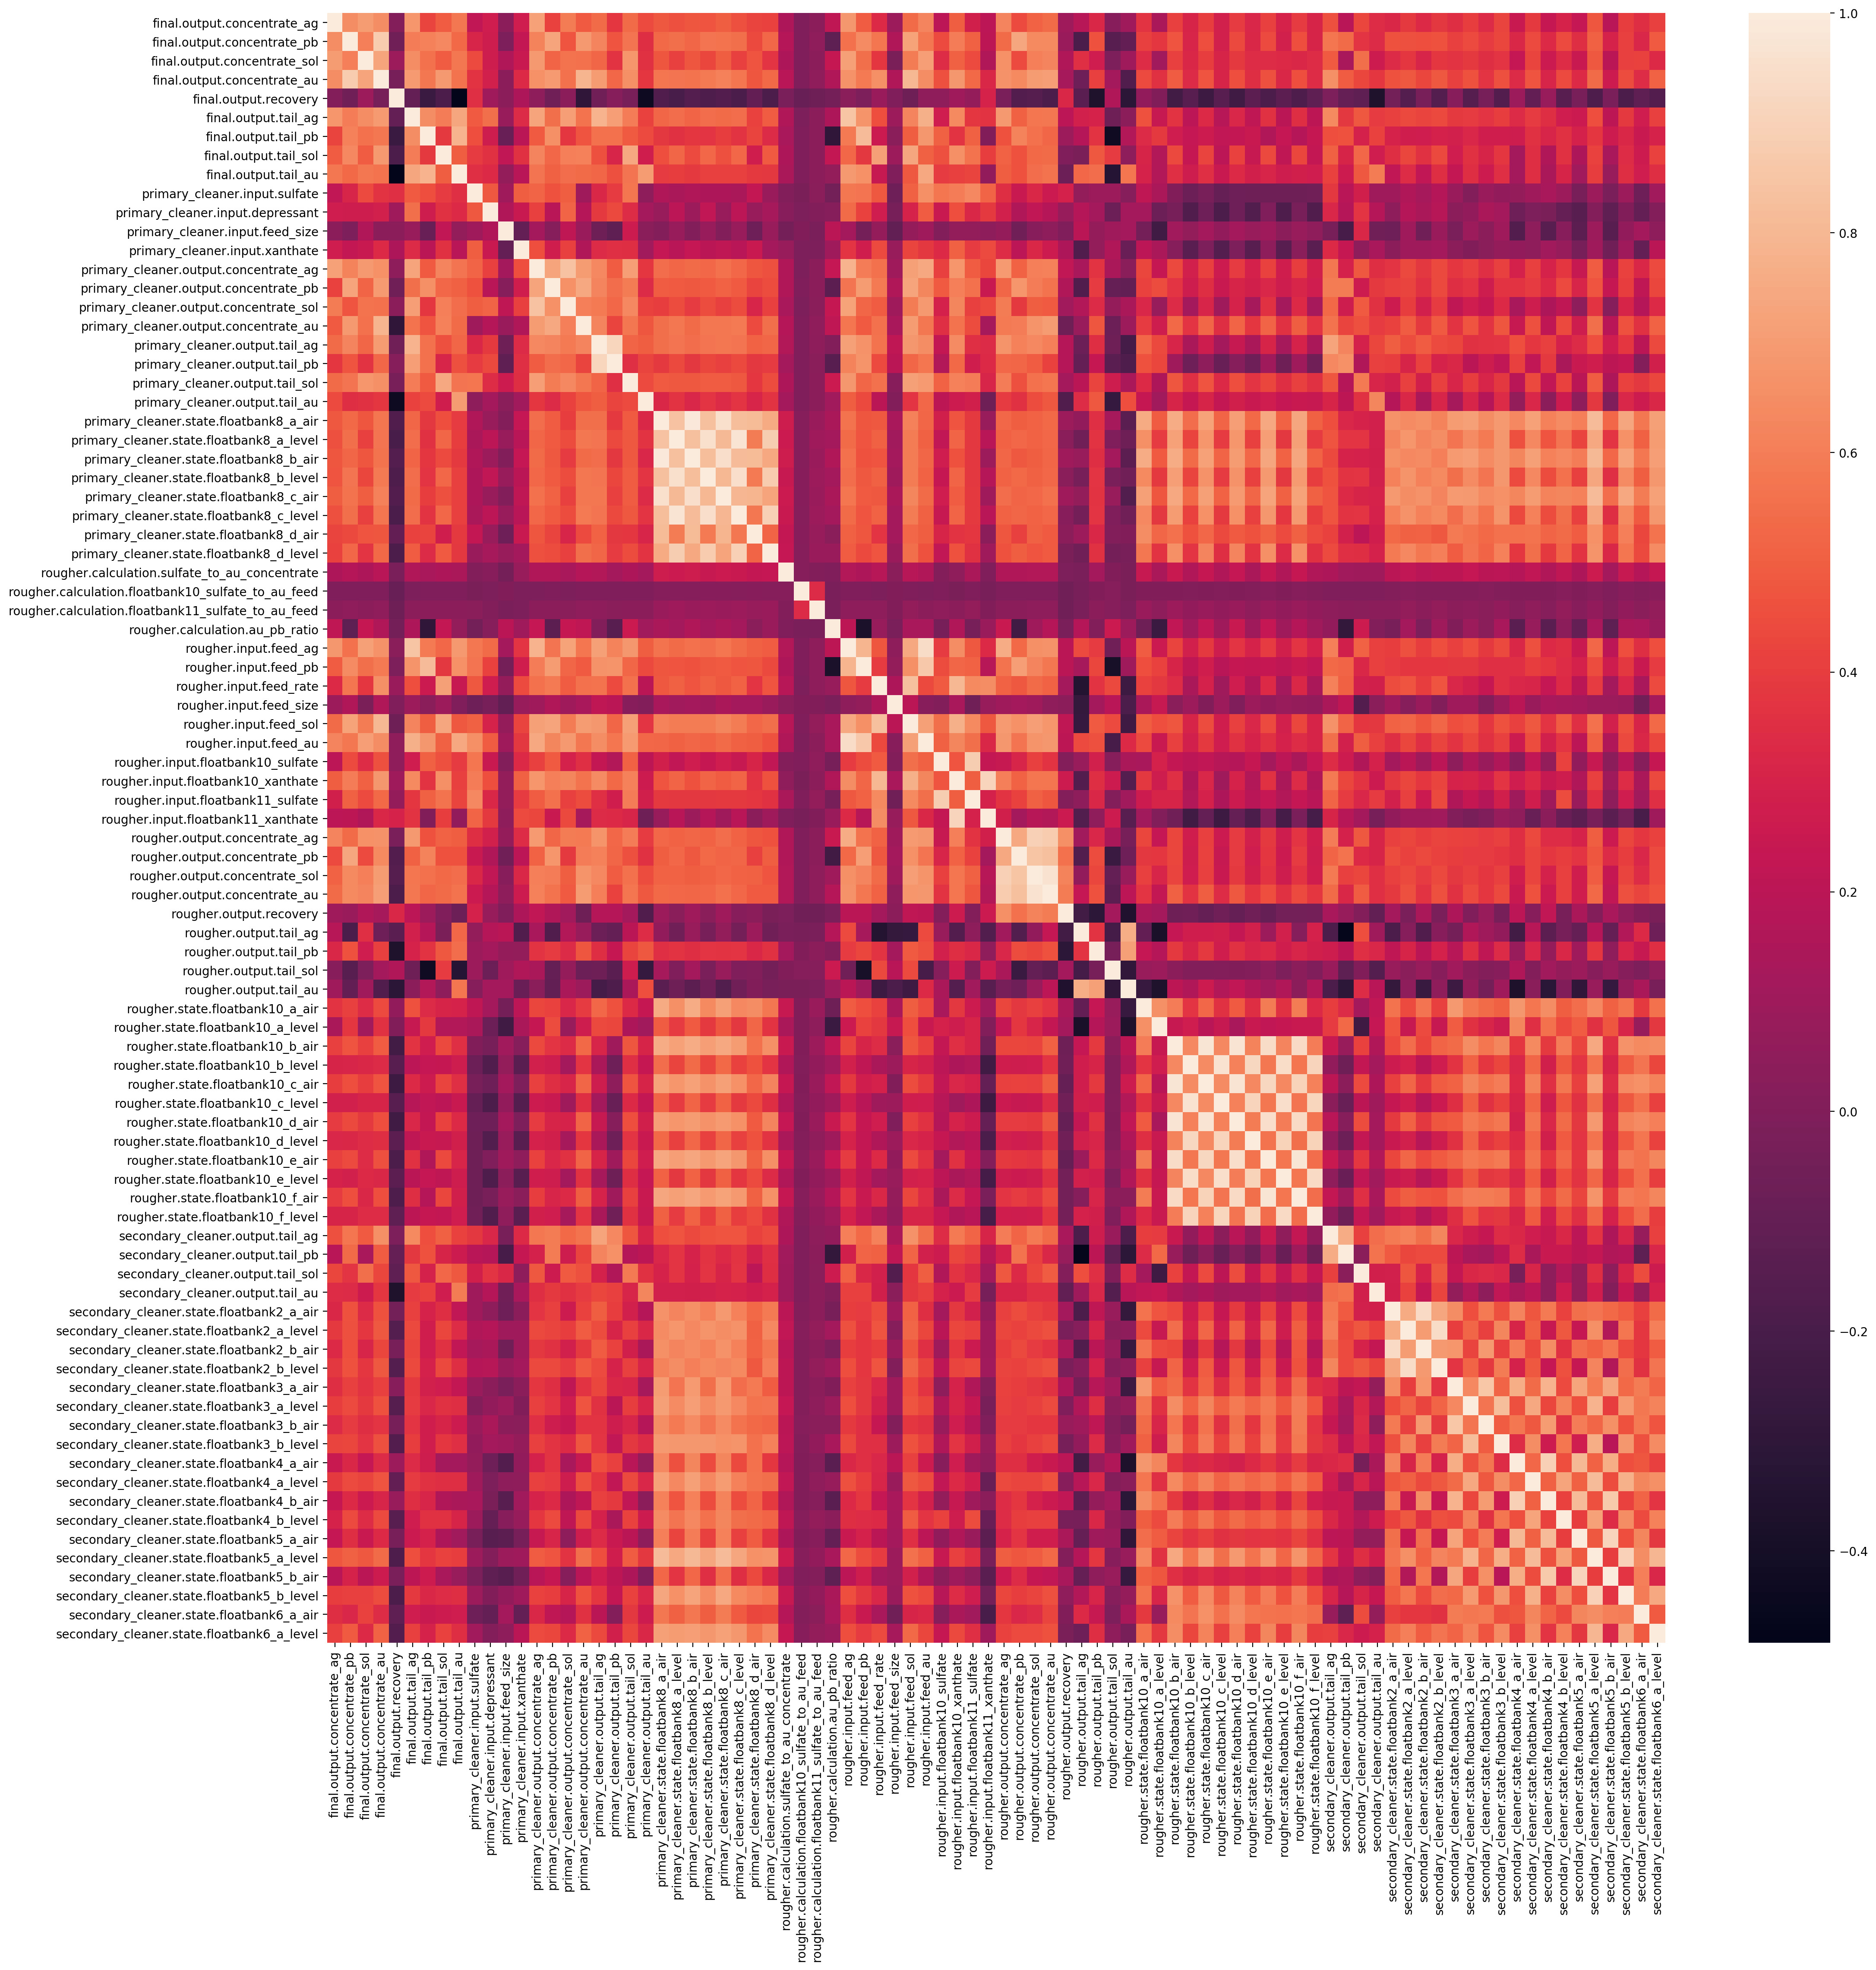

In [47]:
with Image(25, 25):
    sns.heatmap(full.corr())

- Наибольшая корреляция присутствует между признаками, связанными с флотационными установками.
- Выходной продукт и входные ресурсы имеют слабую корреляцию с другими признаками. Очевидно, они связаны, но не впрямую.

Мы подробнее изучим данные, когда будем проводить исследовательский анализ.

Подобно выборкам для обучения и теста, мы удалим все пропуски.

In [48]:
full.dropna(inplace=True)

Проверим датасет на дубликаты.

In [49]:
full.duplicated().sum()

0

Дубликатов нет.

### Вывод по полному набору данных
- Мы бегло посмотрели на данные и их корреляцию.
- Поскольку у нас достаточно много данных, мы отбросили строки, где есть пропуски. Такой подход снизит вероятность исказить распределения при заполнении пропусков. Тем более, что мы имеем ограниченное представление о техническом процессе.

---

### Вывод из предобработки данных
- Мы рассмотрели данные из каждого имеющегося у нас файла. Установили время наблюдения в качестве индекса. Изучили матрицу корреляции признаков.
- Рассмотрели признаки по их смыслу и подумали над тем, какие из них допустимо оставить с учётом возможной утечки данных.
- Удалили данные, в которых содержались пропуски, поскольку мы не обладаем достаточным опытом в доменной области, чтобы предлагать другие варианты работы с пропусками. Тем более, у нас осталось достаточно данных.
- Убедились в отсутствии дубликатов в полном датасете.
- Посчитали на обучающей выборке, насколько значения целевых признаков различаются с ответами, полученными с помощью формулы расчёта. Обнаружили, что у целевых признаков неверный масштаб. Привели их к масштабу от *0* до *1*. В полном наборе тоже.
- Тестовая выборка заслуживает отдельного внимания:
    - Мы подгрузили значения целевых признаков из исходного набора данных.
    - Рассмотрели столбцы, которые выброшены из тестовой выборки, и сделали предположение, что эти данные не могут быть известны заранее.
    - Удалили лишние столбцы и из обучающей выборки.
    - Выделили столбцы с типом `state`, которые, по нашему предположению, не являются управляющими. *Мы обучим модели с ними и без них и таким образом определим их ценность.*
- Также мы создали дополнительную обучающую и тестовую выборки для предсказания качества этапа флотации, поскольку флотация идёт до остальных этапов очистки.
    
Мы уже проделали непростую работу, но у нас получилось распутать данные, извлечь из них полезную информацию и подготовиться к дальнейшим этапам работы таким образом, чтобы не возвращаться к предобработке и заниматься анализом.

---

# 2. Анализ данных
Для анализа мы будем использовать полный набор данных.

In [50]:
# Привычное название
data = full

### Концентрация металлов
Изучим, как меняется концентрация металлов на разных этапах обработки. Нас интересуют золото, серебро и свинец.

In [51]:
metals = ['au', 'ag', 'pb']

In [52]:
# Столбцы с концентратами
met_conc = [col for col in full.columns if any(f'concentrate_{m}' in col for m in metals)]
met_conc

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

In [53]:
# Разделили столбцы по металлам
au, ag, pb = [list(filter(lambda col: m in col, met_conc))[::-1] for m in metals]

In [54]:
# Выделили этапы, в которых получаются концентраты
stages = sorted(list(set([col[:col.index('.')] for col in met_conc])), reverse=True)
stages

['rougher', 'primary_cleaner', 'final']

In [55]:
# Собрали в таблицу и подтянули средние значения по названиям столбцов
mconc_df = pd.DataFrame(zip(au, ag, pb), index=stages, columns=metals).applymap(lambda x: data[x].mean())
mconc_df

,au,ag,pb
rougher,20.052152,12.084945,7.553095
primary_cleaner,32.065559,8.674853,9.884018
final,44.307437,5.190976,9.997593


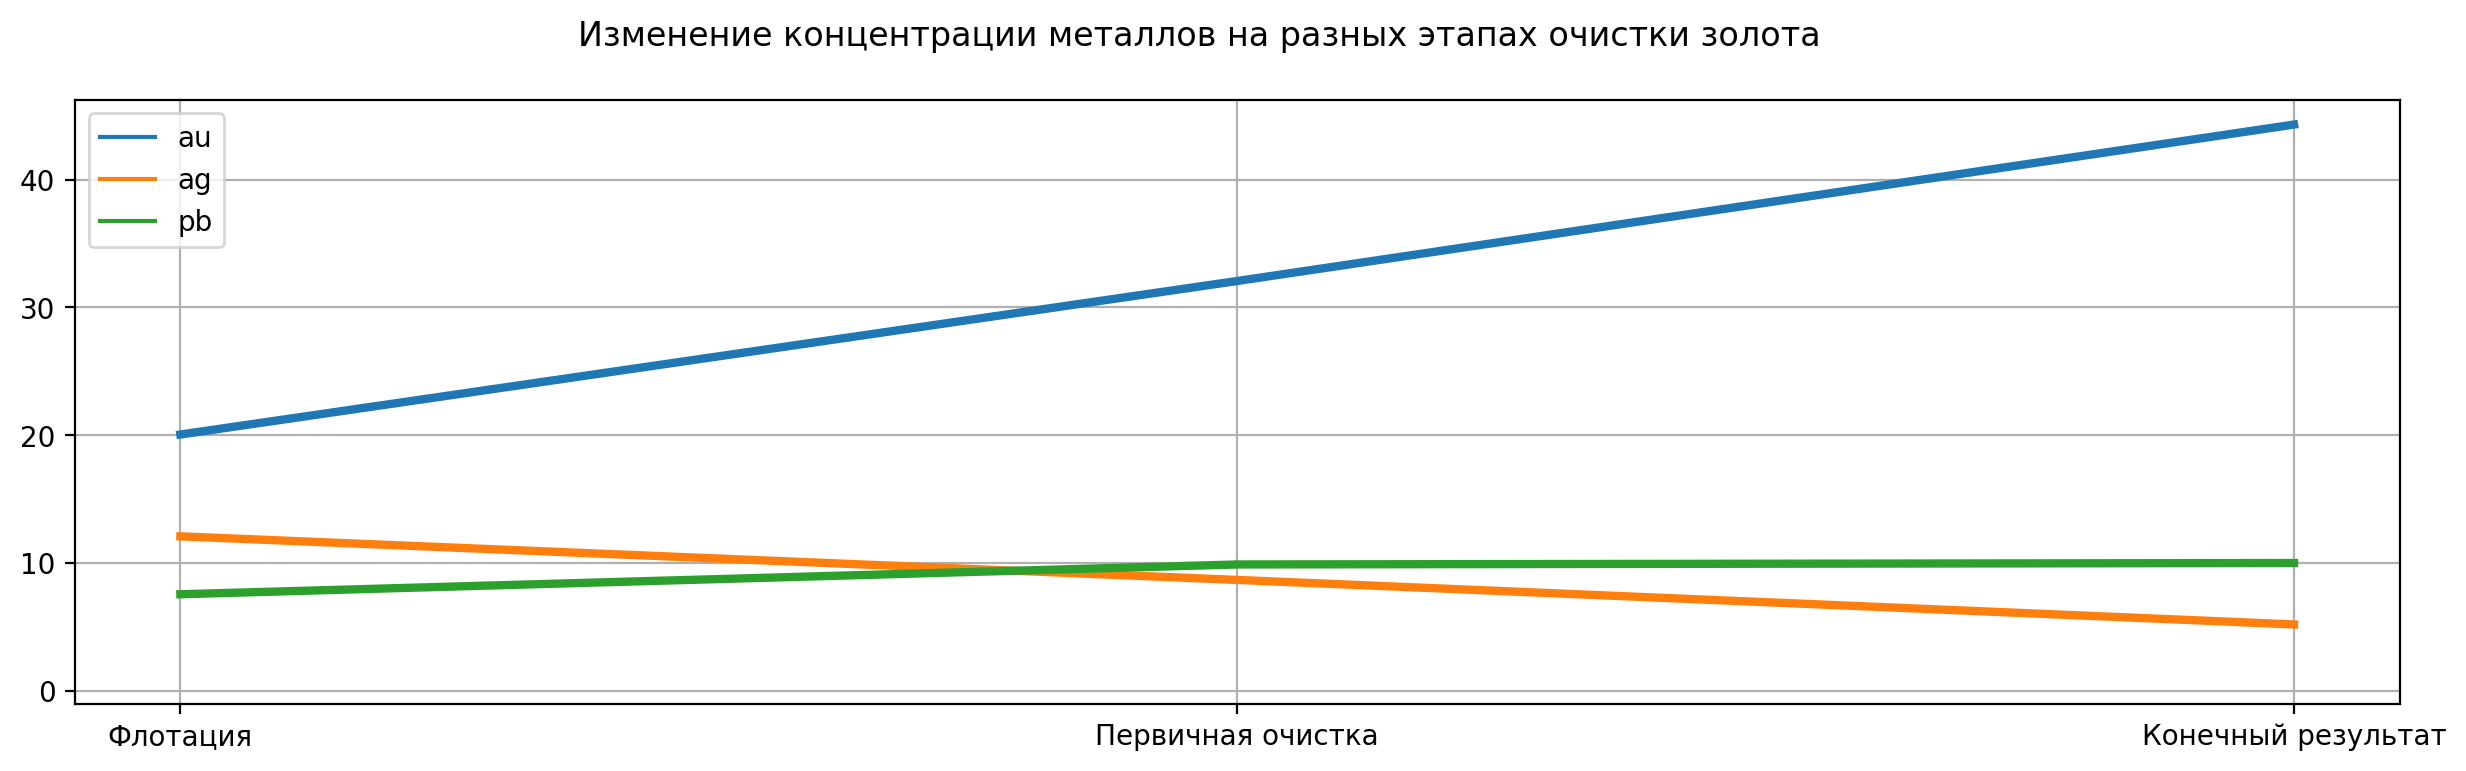

In [56]:
# Рисуем рисунок
with Image(st='Изменение концентрации металлов на разных этапах очистки золота', grid=True):
    sns.lineplot(data=mconc_df, sort=False, lw=3, dashes=False)
    plt.ylim(-1)
    plt.xticks(mconc_df.index, labels=['Флотация', 'Первичная очистка', 'Конечный результат'])

- Наблюдаем, что концентрация золота на протяжении всего процесса увеличивается. Причём изменение сильнее, чем у других металлов.
- Концентрация серебра несколько снижается. Видимо, здесь это расходный материал.
- Концентрация свинца немного увеличивается к концу очищения.
- Изменения концентраций практически линейные. *Нужна ли нам первичная очистка как этап при обучении?*

In [57]:
# Запишем в переменную столбцы primary
primary_cleaner = stages[1]
primary_cleaner

'primary_cleaner'

In [58]:
primary_cols = [col for col in full.columns if primary_cleaner in col]
primary_cols

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level']

---

### Размеры гранул сырья
Сейчас мы посмотрим, как распределяются размеры гранул сырья на обучающей и тестовой выборках.

In [59]:
feed_size = 'rougher.input.feed_size'

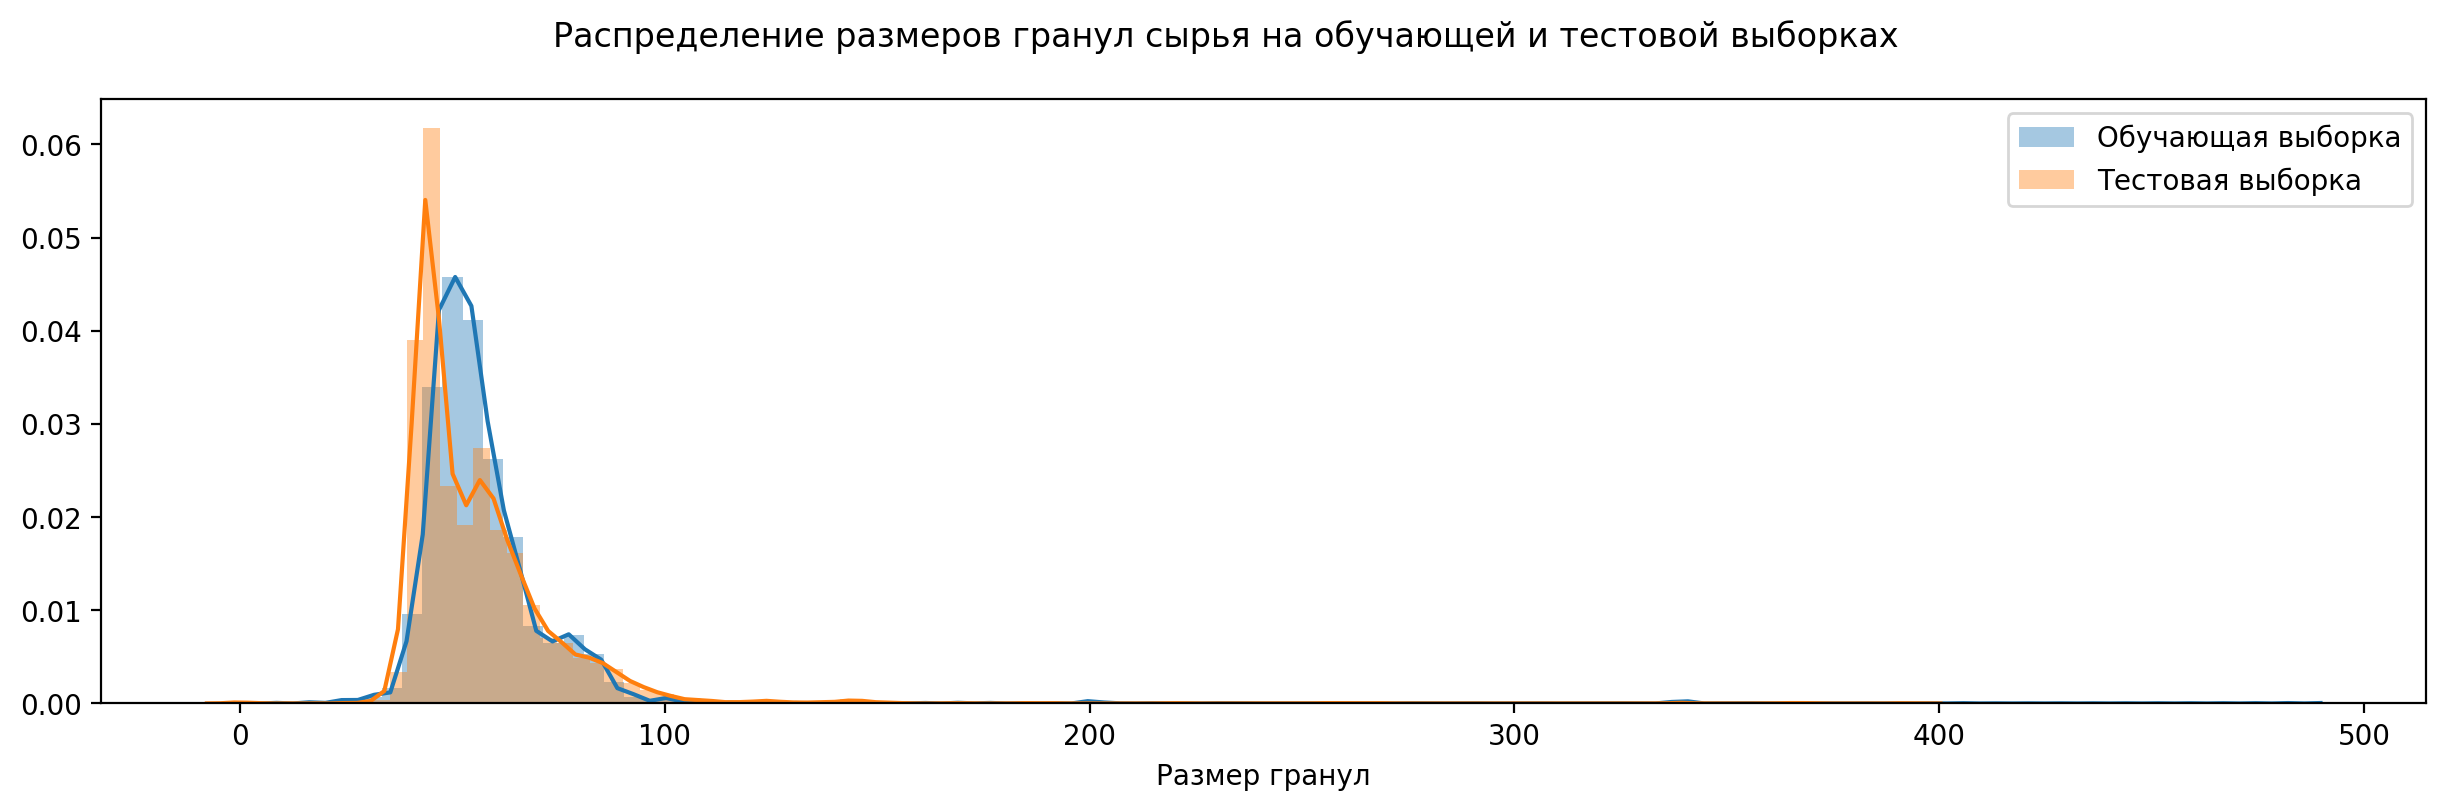

In [60]:
with Image(st='Распределение размеров гранул сырья на обучающей и тестовой выборках', legend='a'):
    sns.distplot(train[feed_size], label='Обучающая выборка', bins=100)
    sns.distplot(test[feed_size], label='Тестовая выборка', bins=100)
    Image.labels('Размер гранул')

- Визуально размеры распределены схожим образом, но стоит проверить сходство выборок, а заодно и нормальность распределений.
- Ещё мы видим, что здесь есть аномально высокие значения. Их практически не видно, но гистограмма отрисовалась бы в менее широком диапазоне значений.

In [61]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

In [62]:
# Проверим нормальность функцией-гипотезой
for df in [train, test]:
    hypo(shapiro(df[feed_size]))

p-value = 0.0
p-value < 0.05
p-value = 0.0
p-value < 0.05


Распределения не являются нормальными. Применим критерий Манна-Уитни.

In [63]:
hypo(mannwhitneyu(train[feed_size], test[feed_size]))

p-value = 8.505017889136345e-49
p-value < 0.05


- Вполне ожидаемо при таких непохожих распределениях получить *p-value* ниже уровня значимости и узнать, что они далеки от того, чтобы называться одинаковыми.
- Из всего этого следует, что данный признак **может внести искажения в работу модели**, а нам этого не хотелось бы. Поэтому мы рассмотрим возможность исключения этого признака из выборок.

---

### Суммарная концентрация веществ
Мы поисследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, попытаемся найти аномальные значения в суммарном распределении.

Выберем столбцы, которые нас интересуют.

In [64]:
# Сырьё для флотации
raw_input = [col for col in full.columns if col.startswith('rougher.input') and not ('size' in col or 'rate' in col)]
raw_input

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [65]:
# Черновой концентрат
rougher_conc = [col for col in full.columns if col.startswith('rougher.output.concentrate')]
rougher_conc

['rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [66]:
# Финальный концентрат
final_conc = [col for col in full.columns if col.startswith('final.output.concentrate')]
final_conc

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au']

У нас получились наборы столбцов, соответствующие концентрациям веществ на трёх стадиях процесса. Теперь просуммируем эти значения для каждого объекта и создадим три дополнительных столбца с суммарными концентрациями на каждый этап.

In [67]:
result_cols = raw_input, rougher_conc, final_conc

In [68]:
# Создадим столбцы циклом
for cols, result in zip(result_cols,
                        ['raw_input', 'rougher_concentrate', 'final_concentrate']):
    # Результирующий столбец = сумма соответствующих столбцов
    full.loc[:, result] = sum(full[col] for col in cols)

In [69]:
# Посмотрим на получившиеся столбцы
total_conc = full.iloc[:, -3:]
total_conc.head()

,raw_input,rougher_concentrate,final_concentrate
date,,,
2016-01-15 00:00:00,87.517201,66.424950,63.644396
2016-01-15 01:00:00,86.644829,67.012710,63.957723
2016-01-15 02:00:00,86.852847,66.103793,64.311180
2016-01-15 03:00:00,86.783844,65.752751,63.573449
2016-01-15 04:00:00,82.171162,65.908382,64.004667


У нас получились распределения суммарных концентраций всех участвующих в процессе веществ. Теперь мы можем посмотреть на них глазами.

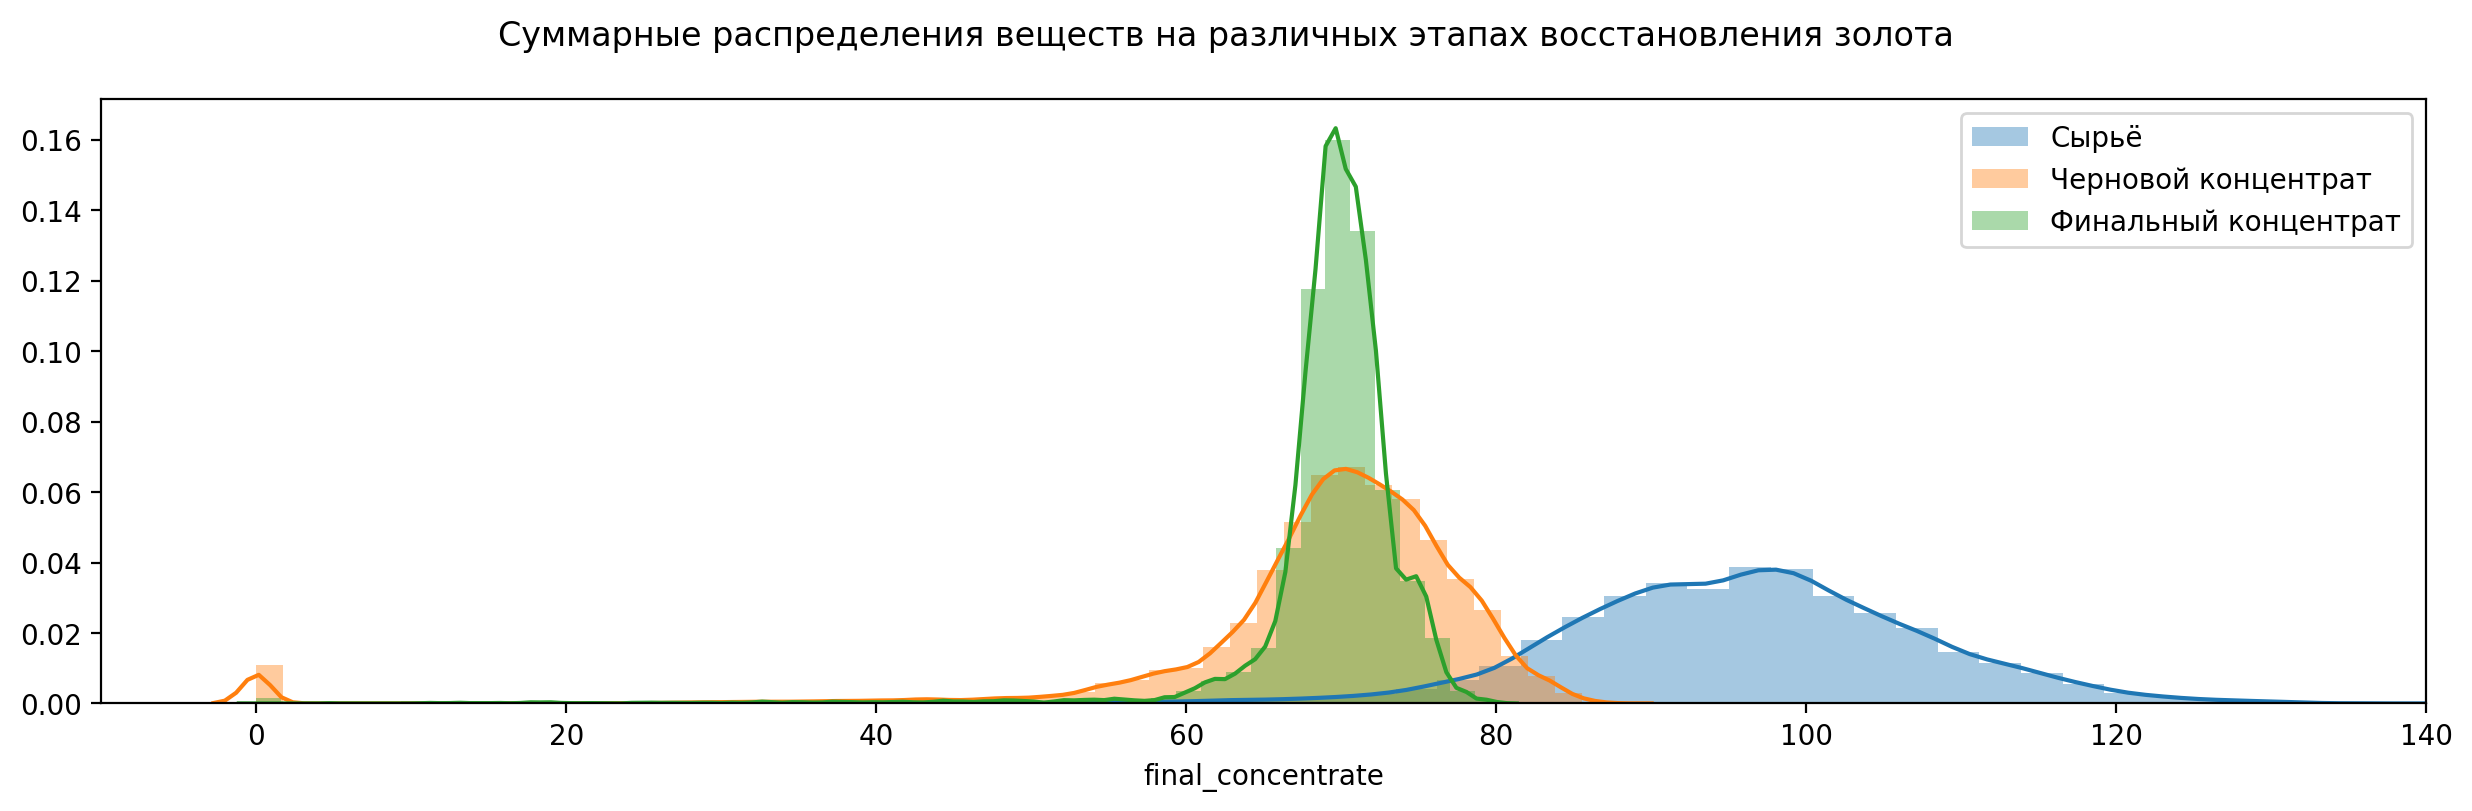

In [70]:
with Image(st='Суммарные распределения веществ на различных этапах восстановления золота', legend='a'):
    for col, l in zip(total_conc.columns,
                      ['Сырьё', 'Черновой концентрат', 'Финальный концентрат']):
        sns.distplot(total_conc[col], label=l)
    plt.xlim(-10, 140)

Странное дело: мы видим, что часть распределения приходится на значения, близкие к нулю. Это похоже на выбросы, и такие значения могут сбить модель с толку при обучении. Причём, судя по всему, такое поведение не заметно на самом начальном этапе. Мы нарисуем ящики с усами, чтобы лучше увидеть диапазоны нормальных значений.

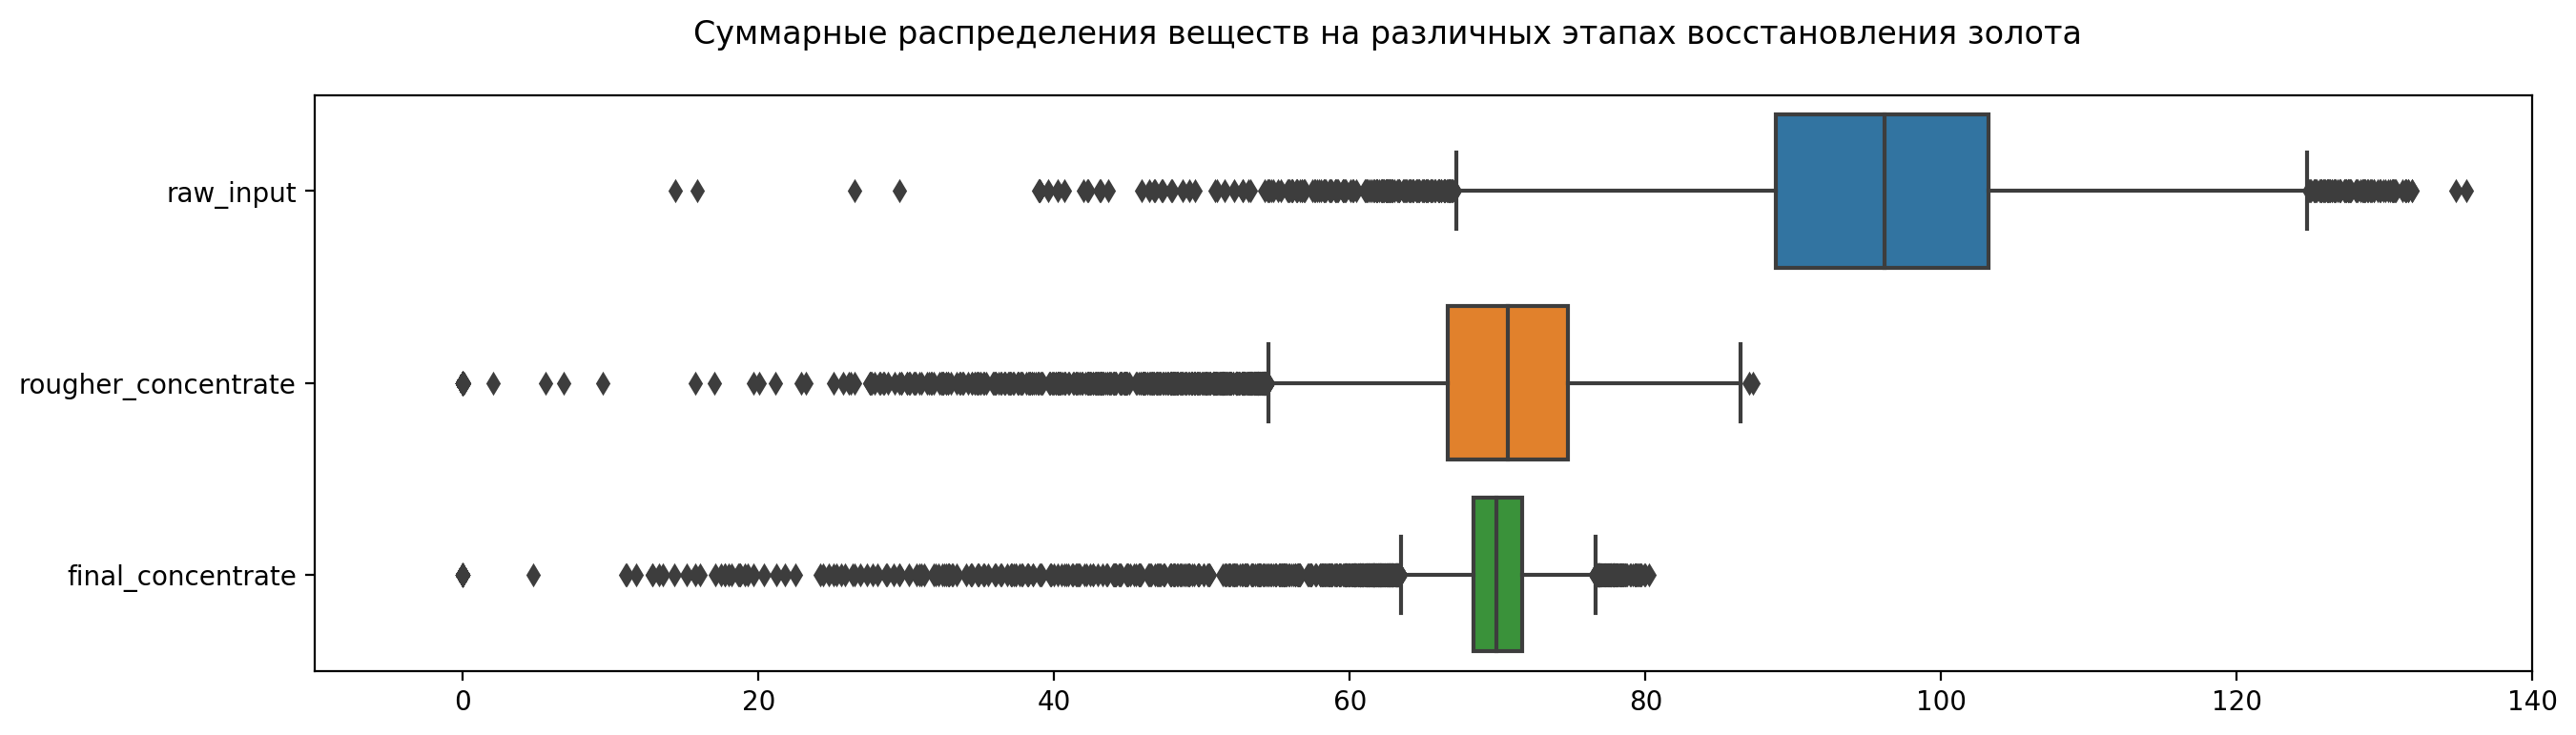

In [71]:
with Image(st='Суммарные распределения веществ на различных этапах восстановления золота'):
    sns.boxplot(data=total_conc, orient='h')
    plt.xlim(-10, 140)

Поскольку у нас получилось большое количество выбросов за пределами усов во всех признаках, мы оставим только те значения, которые лежат в 96% доверительном интервале. (Мы выявили это значение как оптимальное опытным путём).

In [72]:
# Делаем отсечку
conc_clean = ci_strip(total_conc, ci=0.96)

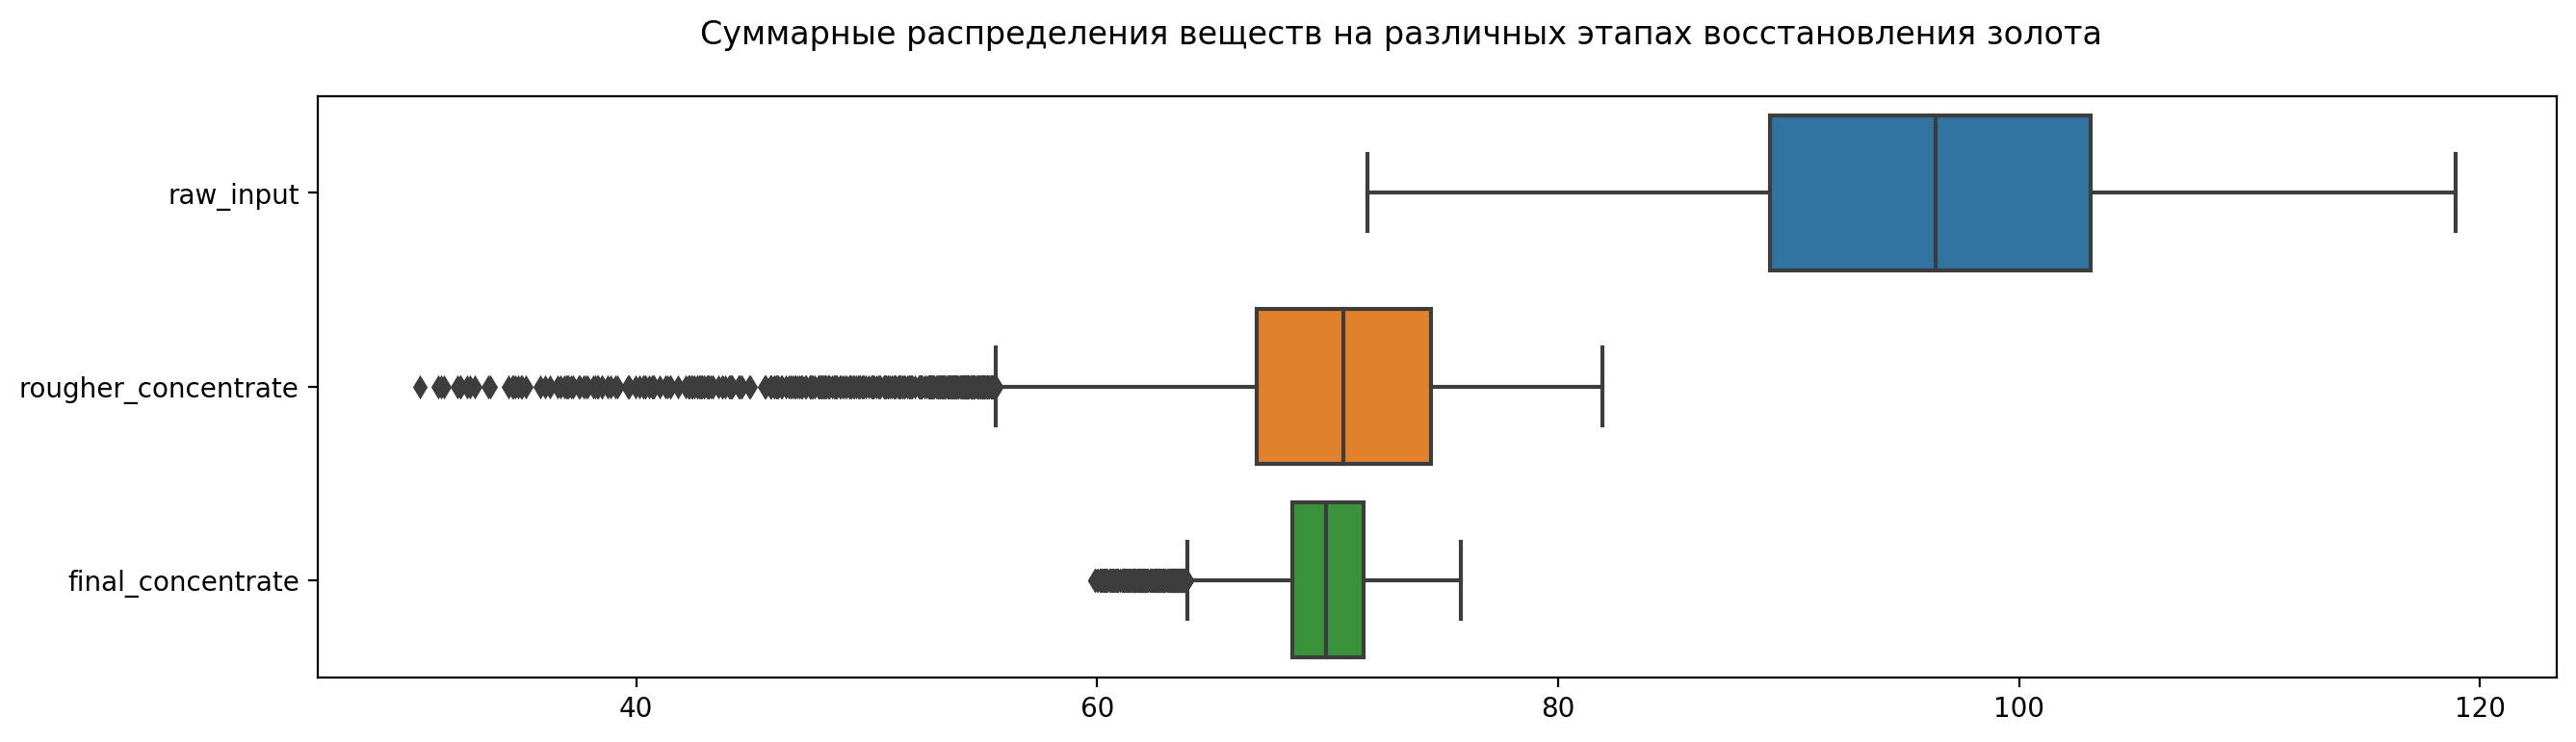

In [73]:
# Проверяем, что осталось
with Image(st='Суммарные распределения веществ на различных этапах восстановления золота'):
    sns.boxplot(data=conc_clean, orient='h')

Выбросы остались, но они не пугают нас так сильно. Проверим, насколько наши новые данные отличаются от данных с аномалиями при помощи критерия Манна-Уитни.

In [74]:
for col in ['raw_input', 'rougher_concentrate', 'final_concentrate']:
    print(col)
    hypo(mannwhitneyu(total_conc[col], conc_clean[col]))

raw_input
p-value = 0.05180054805423336
p-value > 0.05
rougher_concentrate
p-value = 0.47659902469454923
p-value > 0.05
final_concentrate
p-value = 0.4754220096608639
p-value > 0.05


Все три столбца показывают достаточное *p-value*, чтобы мы могли быть уверены в их похожести на своих исходных братьев.

Теперь отбросим из тестовой и обучающей выборок строки, соответствующие отброшенным строкам здесь.

In [75]:
# Обучающая выборка - только индексы без аномалий
train = train[train.index.isin(conc_clean.index)]

In [76]:
# Тестовая выборка
test = test[test.index.isin(conc_clean.index)]

In [77]:
print_shapes(train, test)

(9887, 54)
(4351, 54)


### Вывод из исследовательского анализа данных
- Мы посмотрели на то, как меняется концентрация металлов по мере восстановления золота. Увидели изменение, близкое к линейному. Если убрать этап первичной очистки, то мало что изменится (мы это ещё проверим).
- Обнаружили, что распределения размеров гранул сырья в обучающей и тестовой выборках не одинаковы. Это натолкнуло нас на мысль, что данный признак может помешать обучению модели.
- Рассмотрели суммарные концентрации веществ на разных этапах процесса. Обнаружили аномально низкие значения, близкие к нулю. Избавились от выбросов при помощи доверительного интервала в *96%*, сохранив достаточную похожесть распределений, чтобы не отвергать нулевую гипотезу. Отбросили эти же потенциально аномальные строки из обучающей и тестовой выборок.

---

# 3. Модель
Мы начнём обучение модели с написания функции-метрики **sMAPE**, которая станет нашим критерием оценки качества и будет искать ошибку в процентах.

In [78]:
def smape(true, preds):
    """Symmetric Mean Absolute Percentage Error, симметричное среднее абсолютное процентное отклонение.
    
    Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Одинаково учитывает масштаб и целевого признака, и предсказания."""
    return np.nanmean(np.abs(true - preds) / ((np.abs(true) + np.abs(preds)) / 2))

In [79]:
# Функция для финальной оценки качества
def total_smape(rougher, final):
    return 0.25 * rougher + 0.75 * final

Теперь, когда у нас есть функции для оценки качества, Мы приступаем к работе с моделями. Будем обучать их в два этапа.

---

### Обучение модели для оценки качества флотации
Мы заранее подготовили наборы данных для этапа флотации. Вспомним, как они выглядят.

In [80]:
x_train_float.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11017 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               11017 non-null  float64
 1   rougher.input.feed_pb               11017 non-null  float64
 2   rougher.input.feed_rate             11017 non-null  float64
 3   rougher.input.feed_size             11017 non-null  float64
 4   rougher.input.feed_sol              11017 non-null  float64
 5   rougher.input.feed_au               11017 non-null  float64
 6   rougher.input.floatbank10_sulfate   11017 non-null  float64
 7   rougher.input.floatbank10_xanthate  11017 non-null  float64
 8   rougher.input.floatbank11_sulfate   11017 non-null  float64
 9   rougher.input.floatbank11_xanthate  11017 non-null  float64
 10  rougher.state.floatbank10_a_air     11017 non-null  float64
 11  roughe

Пока нас ничего не смущает, кроме `feed_size`, который будет отличаться на тестовой выборке. Опять же, `state` попробуем отбросить чуть позже.

Посмотрим на целевой признак.

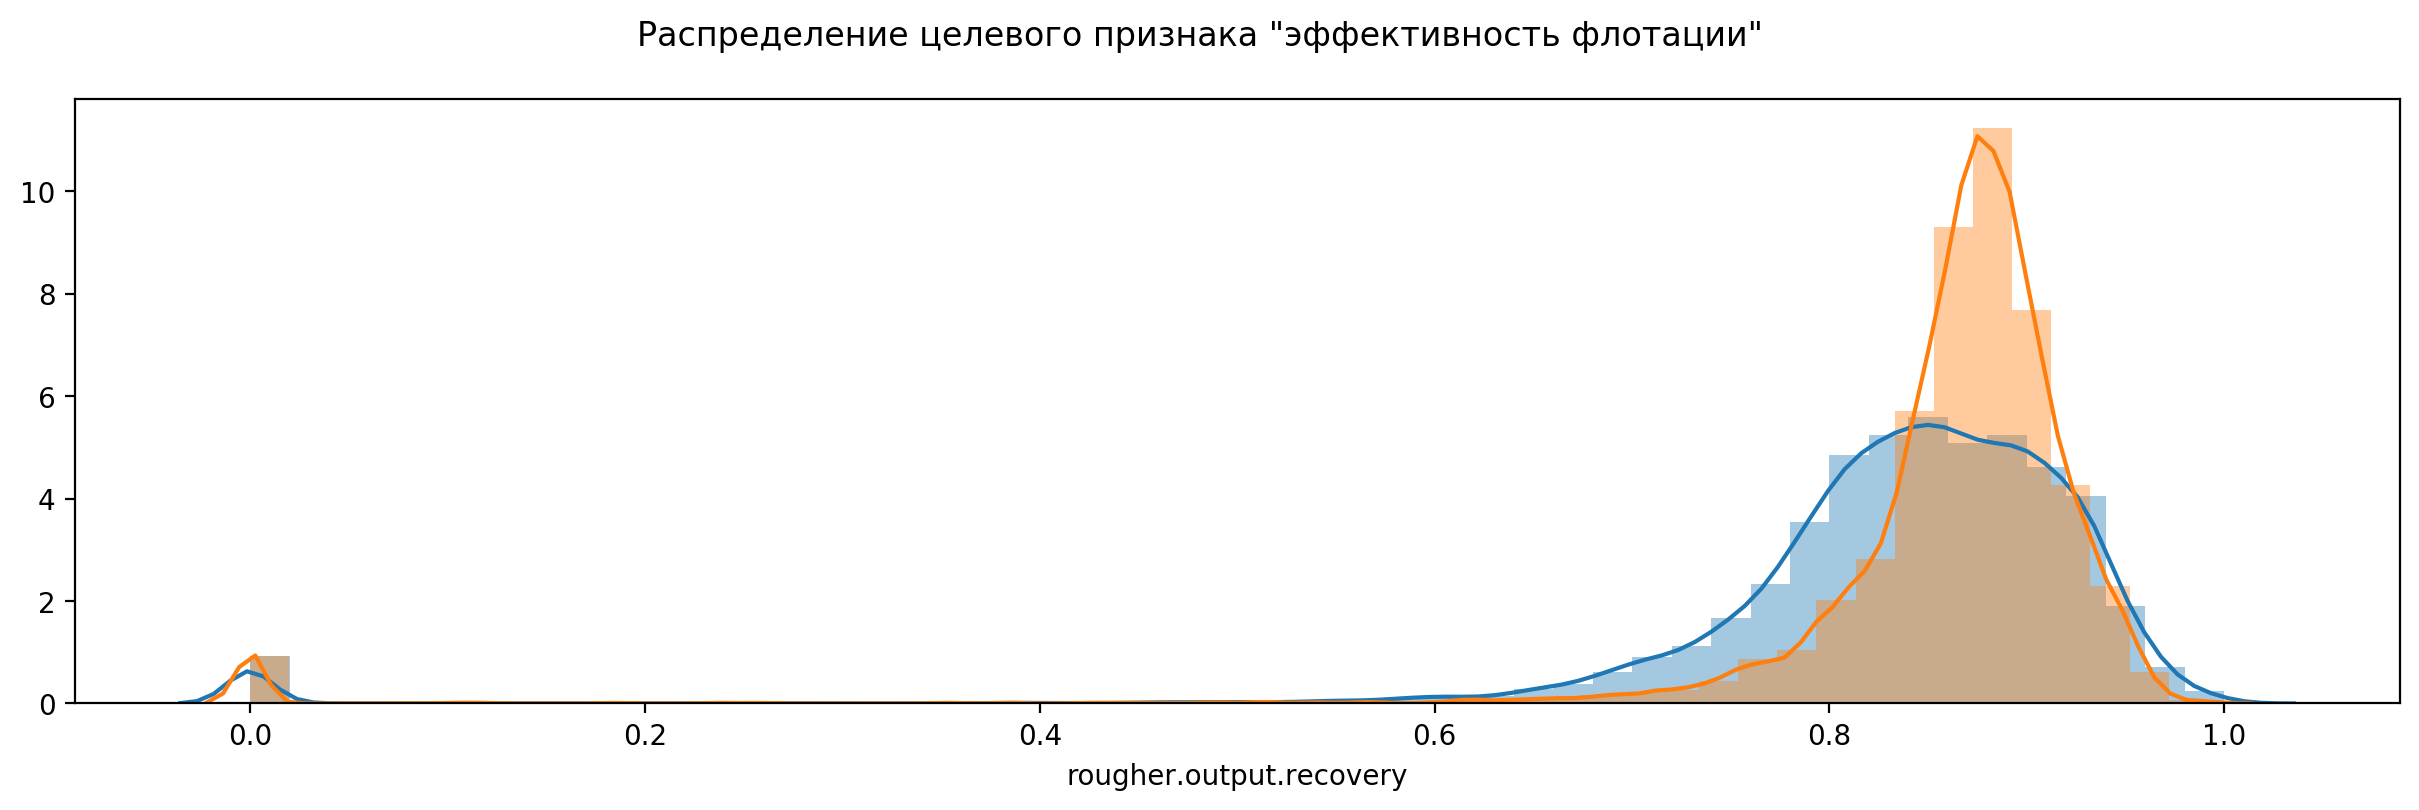

In [81]:
with Image(st='Распределение целевого признака "эффективность флотации"'):
    sns.distplot(y_train_float)
    sns.distplot(y_test_float)

- В обеих выборках есть случаи аномально низких значений. Раз они есть в обеих выборках, вряд ли есть смысл их удалять,
- но мы попробуем обучить модель, которая поможет выявить потенциально аномальные объекты.

---

### Извлечение столбца с аномально низкими значениями recovery
По идее, на тестовой выборке мы не знаем, будет ли `recovery` аномально низким или нет. Поэтому обучим модель-классификатор, которая поможет заметить такие значения, и создадим из её предсказаний дополнительный признак для основной модели. В этом случае нам важен критерий точности `precision`, потому что нам важно не назвать аномальными те наблюдения, которые таковыми не являются.

In [82]:
# Отметим нормальные значения как true
anomaly_float_train = (y_train_float <= 0.1).astype('int')
anomaly_float_test = (y_test_float <= 0.1).astype('int')
anomaly_float_train.sum(), anomaly_float_test.sum()

(206, 96)

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import GridSearchCV

In [84]:
# Зафиксируем случайное состояние
r = 0

In [85]:
# Логистическая регрессия с балансировкой классов
# Обучается на учебной выборке - указанных нами аномалиях
# Гиперпараметры из GridSearch уже переданы в модель
anomaly_detector = GridSearchCV(DecisionTreeClassifier(random_state=r, min_samples_leaf=2, max_depth=4, min_samples_split=2,
                                                      max_leaf_nodes=5),
                                {},
                                scoring='precision')

In [86]:
anomaly_detector.fit(x_train_float, anomaly_float_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features=None,
                                              max_leaf_nodes=5,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbo

In [87]:
# Precision при кросс-валидации на обучающей выборке
anomaly_detector.best_score_

0.23338418041948844

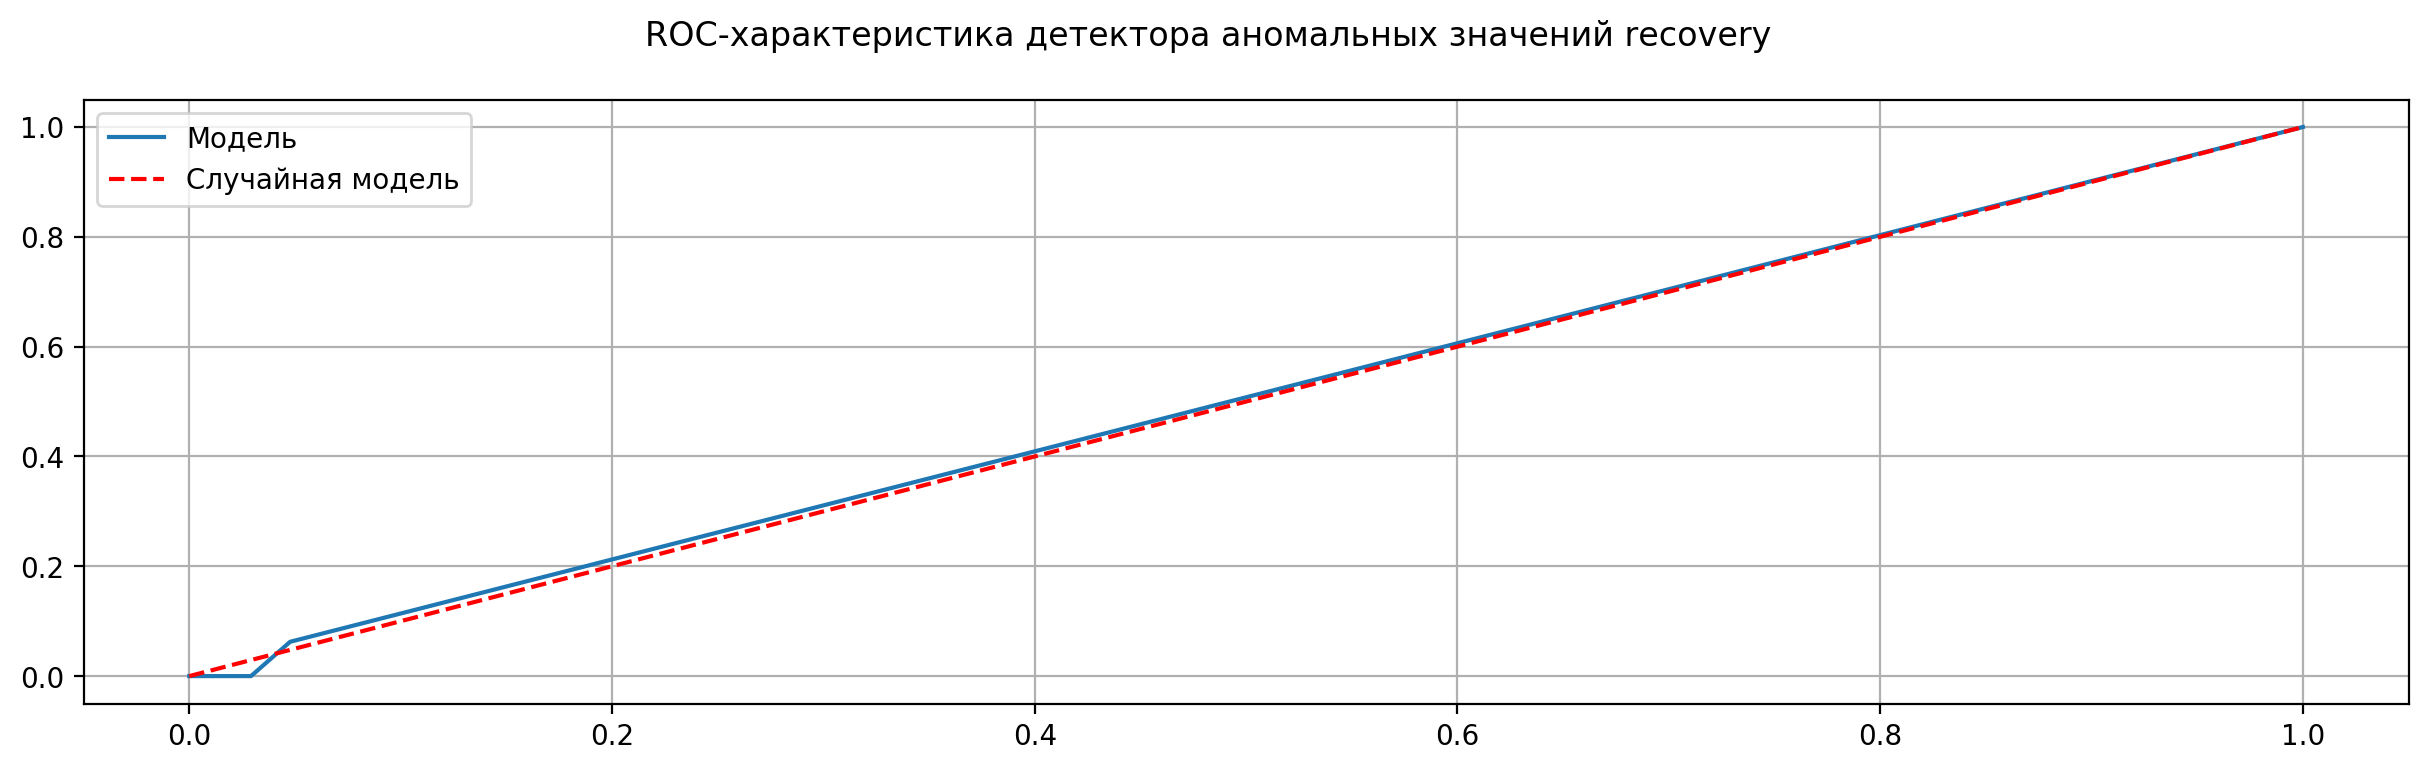

In [88]:
# Посмотрим на ROC-кривую
fpr, tpr, ths = roc_curve(anomaly_float_test, anomaly_detector.predict_proba(x_test_float)[:, 1]) 
with Image(st='ROC-характеристика детектора аномальных значений recovery', legend='a', grid=True):
    sns.lineplot(fpr, tpr, label='Модель')
    plt.plot([0, 1], [0, 1], c='r', ls='--', label='Случайная модель')

- Модель, которую мы хотим обучить, абсолютно бесполезна и не принесёт никакой пользы. Даже дерево решений не сумело найти какую бы то ни было закономерность в тех признаках, которые у нас есть.

Оставим идею с классификатором. В конце концов, мы ищем способ оптимизировать параметры восстановления золота, а это совсем другая задача.

---

### Вернёмся к обучению модели для флотации

Попробуем создать функцию, которая в одно действие делает всё необходимое по обучению и валидации модели.

In [89]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [90]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [91]:
def train_model_cv(model, x, y, scorer, features=None, cv=5, **cv_kws):
    """Обучает модель с возможностью выбора признаков. Проверяет кросс-валидацией. Возвращает среднее значение метрики качества."""
    if features is None:
        features = x.columns
    return np.abs(np.mean(cross_val_score(model, x[features], y, cv=cv, scoring=scorer, **cv_kws)))

Добавим возможность обучать сразу несколько моделей и сравнивать их метрики качества.

In [92]:
def batch_train_cv(model_grid: dict, cv_func: train_model_cv, greater_is_better=False, **train_kws):
    """Собирает результаты кросс-валидации набора моделей в Series."""
    scores = {name: cv_func(model, **train_kws)
              for name, model in model_grid.items()}
    # Запишем результат кросс-валидации каждой модели в словарь
    return pd.Series(scores, name='score').sort_values(ascending=not greater_is_better)

In [93]:
# Обучение для флотации с возможностью выбора модели и признаков
train_float = partial(train_model_cv, x=x_train_float, y=y_train_float, scorer=smape_scorer, cv=5)

- Попробуем обучить несколько разных моделей с разными наборами признаков.
- Вместе с нормальными моделями мы будем обучать `DummyRegressor`, который будет отвечать средними значениями: так мы сразу будем проверять модели на адекватность.

In [94]:
# Сохраним наборы признаков для флотации в словарь
float_cols_grid= {'all': None,
                  'no_feed_size': x_train_float.drop(feed_size, axis=1).columns,
                  'no_state_and_feed_size': x_train_float.drop(state_cols + [feed_size], axis=1, errors='ignore').columns}

In [95]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [96]:
# Выберем и назовём модели
model_grid = {'LGBMRegressor': LGBMRegressor(),
              'LinearRegression': LinearRegression(n_jobs=-1),
              'DecisionTreeRegressor': DecisionTreeRegressor(random_state=r),
              'RandomForestRegressor': RandomForestRegressor(random_state=r, n_jobs=-1),
              'XGBRegressor': XGBRegressor(verbosity=0, random_state=r, n_jobs=-1),
              'CatBoostRegressor': CatBoostRegressor(random_state=r, verbose=False),
              'DummyRegressor': DummyRegressor(strategy='mean')}

Обучим базовые модели циклом с каждым набором признаков и выведем результаты в датафрейме.

In [97]:
# Создаём датафрейм из нескольких series - по столбцу на набор фич
float_base_features = pd.DataFrame({name: batch_train_cv(model_grid, train_float, features=feats)
                                    for name, feats in float_cols_grid.items()})

In [98]:
# Смотрим, что из этого получилось
float_base_features.sort_values('no_feed_size', inplace=True)
float_base_features

,all,no_feed_size,no_state_and_feed_size
LinearRegression,0.098040,0.097682,0.101518
XGBRegressor,0.106258,0.107473,0.119003
LGBMRegressor,0.109290,0.108029,0.124491
DummyRegressor,0.113880,0.113880,0.113880
RandomForestRegressor,0.118921,0.114964,0.130987
CatBoostRegressor,0.121184,0.119223,0.133404
DecisionTreeRegressor,0.168005,0.139145,0.157979


А какая выборка дала лучшие результаты?

In [99]:
# Посчитаем столбцы, давшие минимальное значение для каждой модели
float_base_features.idxmin(1).value_counts()

no_feed_size    5
all             2
dtype: int64

Выходит, что лучшее значение показала линейная регрессия на выборке без признака `feed_size`.

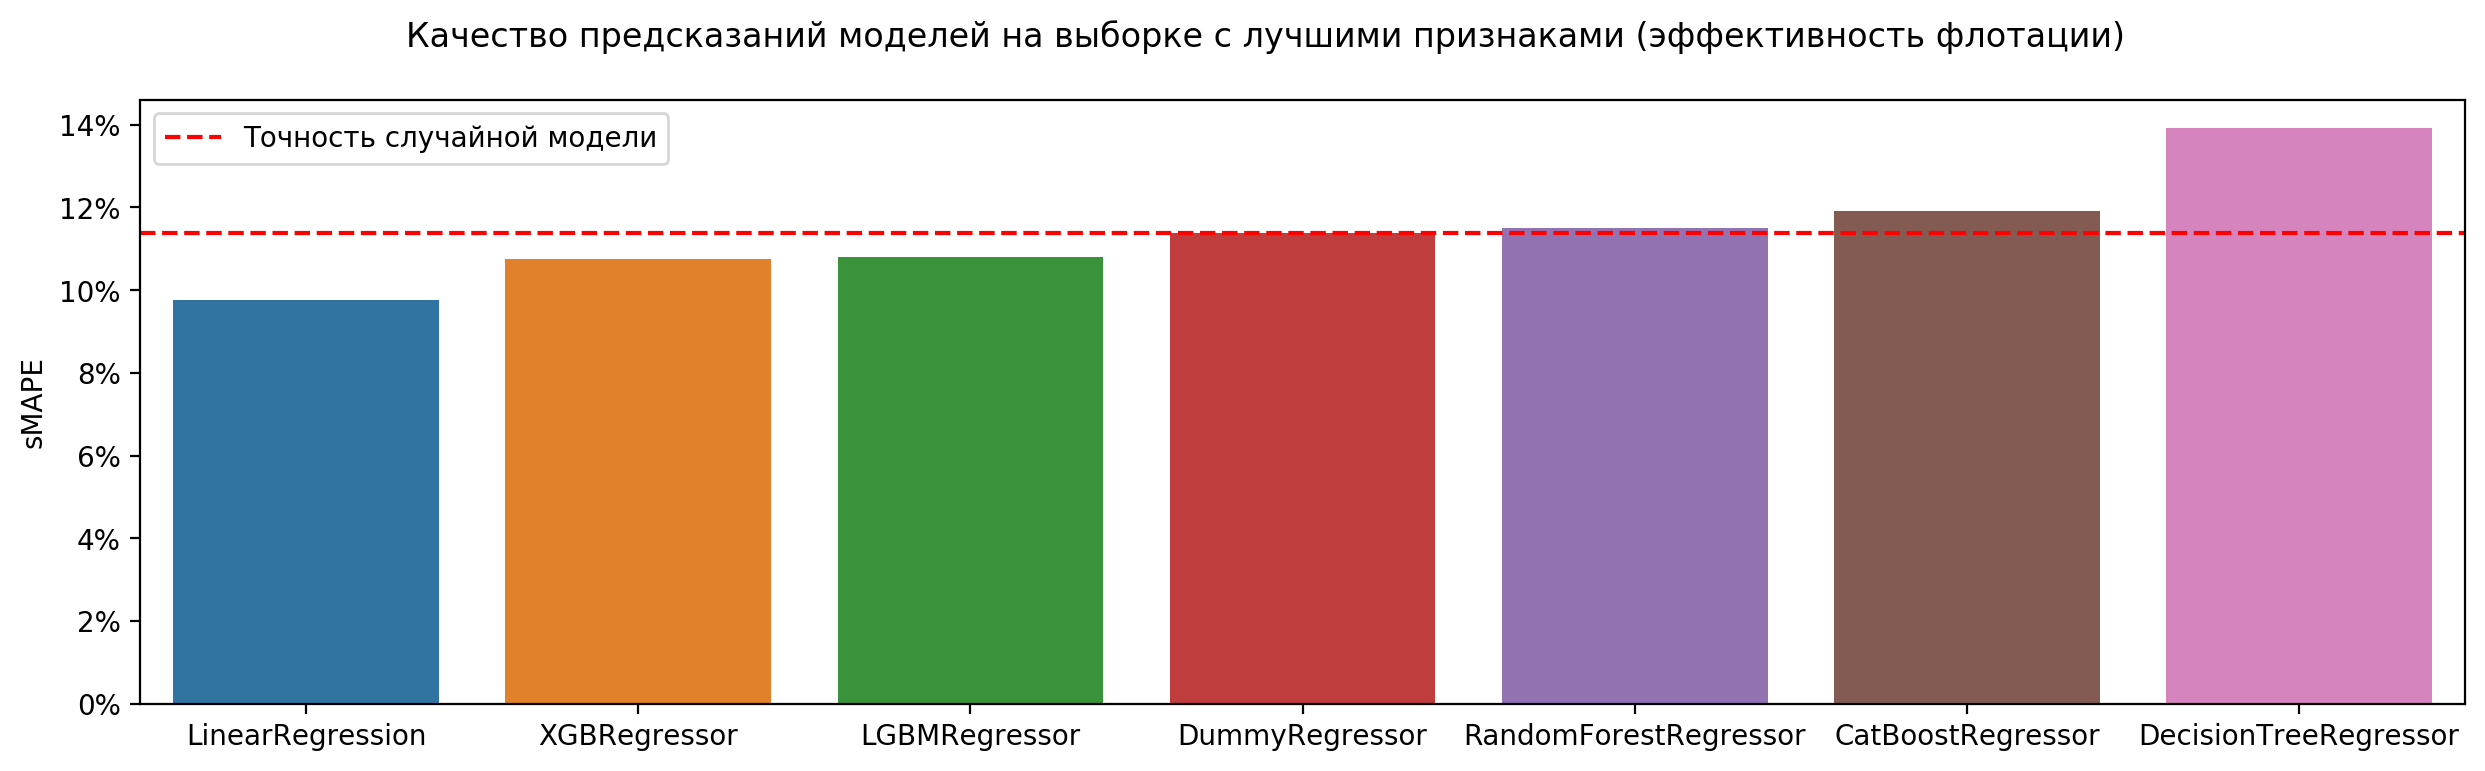

In [100]:
# Посмотрим на диаграмме
with Image(st='Качество предсказаний моделей на выборке с лучшими признаками (эффективность флотации)', legend='a'):
    sns.barplot(float_base_features.index, float_base_features.no_feed_size)
    plt.axhline(float_base_features.loc['DummyRegressor', 'all'], c='r', ls='--', label='Точность случайной модели')
    Image.format_axis(1)
    Image.labels(0, 'sMAPE')

- Всё, что даёт качество хуже случайной модели, имеет смысл отбросить.
- `state`-фичи оказались не самыми бесполезными. Оставим их.

Наиболее перспективные модели для оценки качества флотации - это линейная регрессия и `XGBoost`: мы попробуем поиграть с его настройками: вдруг получится улучшить его качество?

In [101]:
# Сохраним лучшие признаки в переменную
float_features = float_cols_grid['no_feed_size']

Мы выполнили grid search и нашли оптимальные параметры, поэтому для экономии времени просто запишем готовые параметры в модель.

In [102]:
%%time
float_xgb = GridSearchCV(XGBRegressor(random_state=0, verbosity=0, booster='gblinear', n_jobs=-1), {},
                         scoring=smape_scorer, cv=5).fit(x_train_float[float_features], y_train_float)

CPU times: user 6.99 s, sys: 59.2 ms, total: 7.05 s
Wall time: 934 ms


In [103]:
float_xgb.best_score_

-0.10122160787974759

Точность `XGBoost` всё равно не превзошла линейную регрессию.

Попробуем улучшить показатели линейной регрессии.

In [104]:
float_linear = GridSearchCV(LinearRegression(),
                            {'normalize': [True, False],
                             'fit_intercept': [True, False]},
                           scoring=smape_scorer, cv=5).fit(x_train_float[float_features], y_train_float)

In [105]:
np.abs(float_linear.best_score_)

0.09768188235899997

Регрессия в любом случае оказывается лучше. Сохраним эту модель и испытаем на тестовой выборке.

In [106]:
# Сохраним модель для предсказания эффективности флотации.
float_model = float_linear.best_estimator_
float_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [107]:
# Узнаем ошибку модели на тестовой выборке.
float_preds = pd.Series(float_model.predict(x_test_float[float_features]), index=y_test_float.index)
float_smape = smape(y_test_float, float_preds)
float_smape

0.0932086896303407

Сравним распределения ответов модели и целевого признака.

In [108]:
def dist_compare(true, preds, hypothesis=True, image='dist', **img_kws):
    """Рисует распределения ответов модели и реальных значений целевого признака.
    Проверяет сходство выборок критерием Манна-Уитни."""
    if image:
        with Image(legend='a' if image=='dist' else None, **img_kws):
            if image == 'dist':
                sns.distplot(true, label='true')
                sns.distplot(preds, label='preds')
            if image=='box':
                sns.boxplot(data=[true, preds], orient='h')
                plt.yticks([0, 1], ['true', 'preds'])
    if hypothesis:
        hypo(mannwhitneyu(true, preds))

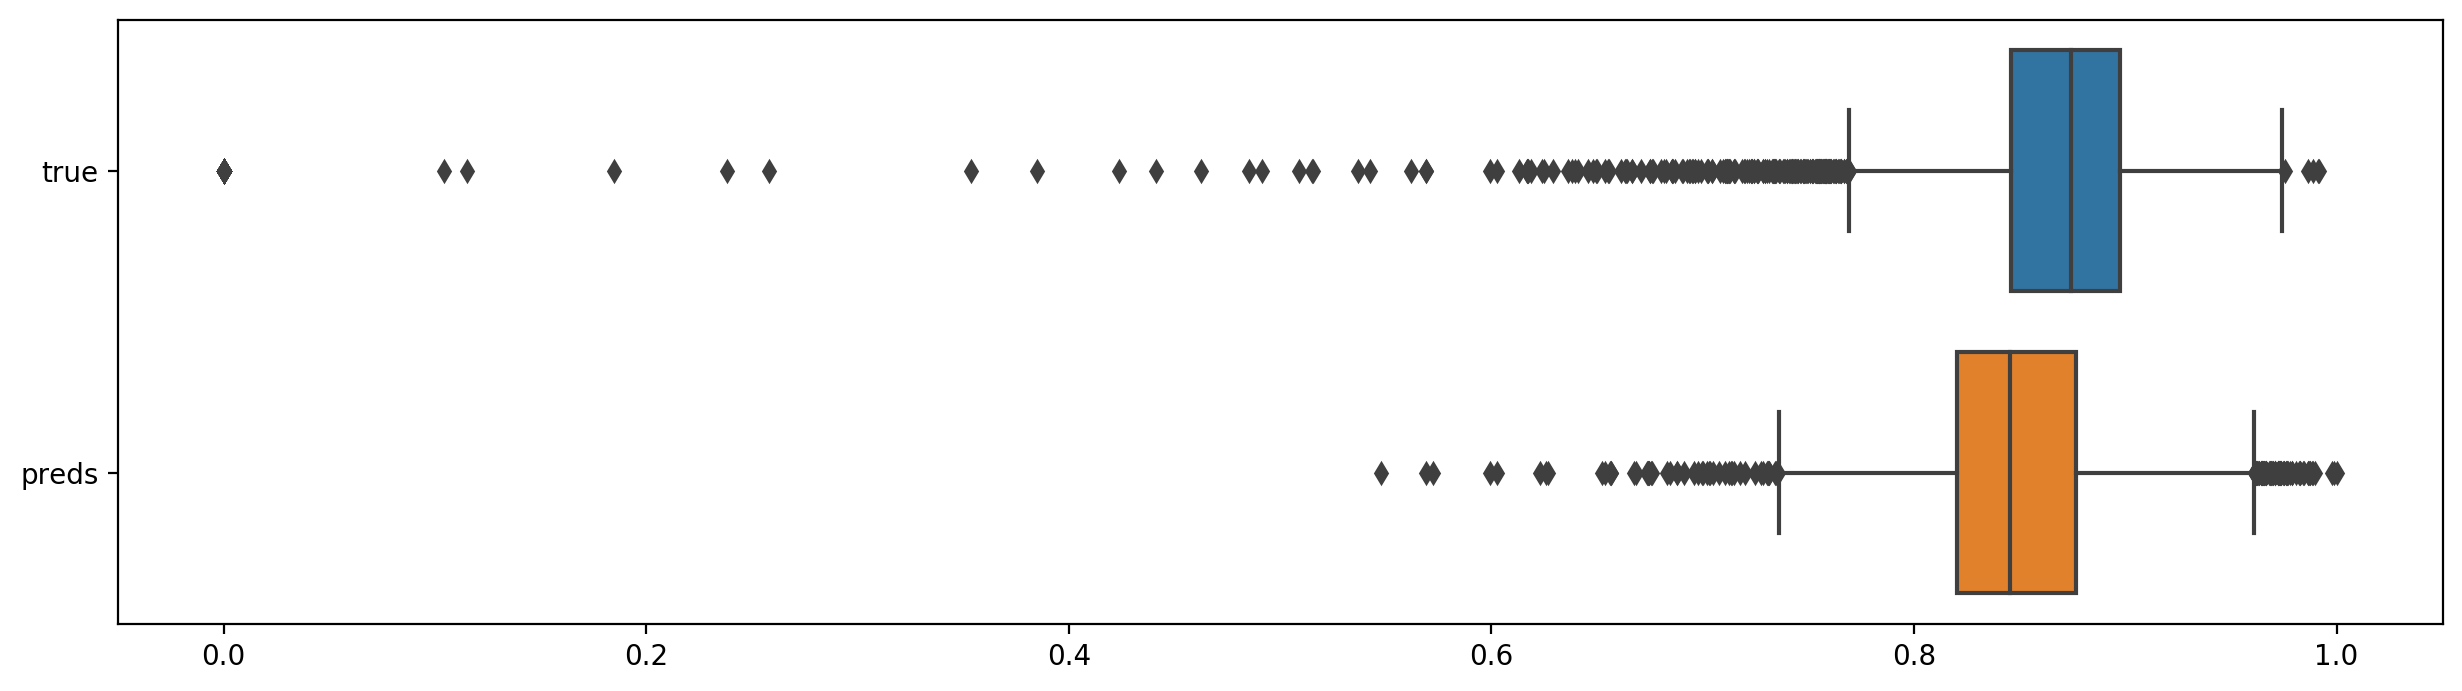

p-value = 2.4012491094197576e-140
p-value < 0.05


In [109]:
dist_compare(y_test_float, float_preds, image='box')

### Вывод из обучения модели для предсказания качества флотации
- Модель не смогла предсказать аномально низкие значения, которые мы видели пытались описать, но в остальном неплохо описала распределение по форме.
- Критерий Манна-Уитни дал слишком маленькое значение *p-value*, чтобы верить в достоверность ответов модели.
- В среднем модель настроена несколько пессимистичнее, чем реальные значения, поэтому мы можем предположить, что реальность будет превосходить значения, предсказанные моделью.

А теперь хорошие новости:
- Даже если модель не предскажет точное значение эффективности на этапе флотации, мы сможем примерно точно определить, будут входные данные оптимальными или нет.
- Мы можем пользоваться моделью как подспорьем при отборе лучших параметров флотации.

Посмотрим, как это сделать.

In [110]:
# Смотрим на реальные значения
y_test_float.describe()

count    5229.000000
mean        0.851322
std         0.129322
min         0.000000
25%         0.846167
50%         0.874230
75%         0.897494
max         0.991697
Name: rougher.output.recovery, dtype: float64

In [111]:
# Берём 50 лучших предсказаний модели и выбираем по ним реальные значения, смотрим на результат
y_test_float[
    float_preds.argsort()[-50:]
].describe()

count    50.000000
mean      0.916815
std       0.039420
min       0.797052
25%       0.892488
50%       0.915955
75%       0.952636
max       0.968692
Name: rougher.output.recovery, dtype: float64

- Как видим, 50 лучших предсказаний в среднем дают нам `recovery` = *91.6%*.
- И, что немаловажно, ни одно из предсказаний не даёт нулевую `recovery`. Не будем загадывать: возможно, что это просто случайность.

---

### Обучение модели для предсказания эффективности очищения конечного продукта
У нас уже есть соображения по тому, как работают признаки, но при исследовательском анализе появилась идея отбросить столбцы с первичной очисткой, потому что концентрация меняется линейно от начала к завершению. Нет гарантии, что это будет работать лучше, потому что на этом этапе добавляются новые реагенты.

In [112]:
# Соберём варианты наборов признаков
final_cols_grid = {'like_float': float_features,
                   'no_primary_no_feed_size' : x_train.drop(primary_cols + [feed_size], axis=1, errors='ignore').columns,
                   'all': None,
                   'no_feed_size': x_train.drop(feed_size, axis=1).columns}

Создадим последовательность действий в том же виде, что и на предыдущем этапе.

In [113]:
# Зададим выборки и метрику качества для кросс-валидации
train_final = partial(train_model_cv, x=x_train, y=y_train, scorer=smape_scorer, cv=5)

In [114]:
# Сделаем таблицу из базовых моделей на разных наборах признаков
final_base_features = pd.DataFrame({name: batch_train_cv(model_grid, train_final, features=feats)
                                    for name, feats in final_cols_grid.items()})

In [115]:
final_base_features.idxmin(1).value_counts()

no_primary_no_feed_size    4
like_float                 1
no_feed_size               1
all                        1
dtype: int64

Действительно, признаки, связанные с первичной очисткой оказалось лучше всего отбросить. 

In [116]:
final_base_features.sort_values('no_primary_no_feed_size', inplace=True)
final_base_features

,like_float,no_primary_no_feed_size,all,no_feed_size
XGBRegressor,0.098229,0.086171,0.090247,0.090009
LinearRegression,0.092544,0.087460,0.095626,0.095550
LGBMRegressor,0.102475,0.087829,0.087175,0.090794
CatBoostRegressor,0.107557,0.091187,0.088783,0.088461
RandomForestRegressor,0.108543,0.098915,0.098953,0.102214
DummyRegressor,0.100528,0.100528,0.100528,0.100528
DecisionTreeRegressor,0.163309,0.151530,0.164660,0.161120


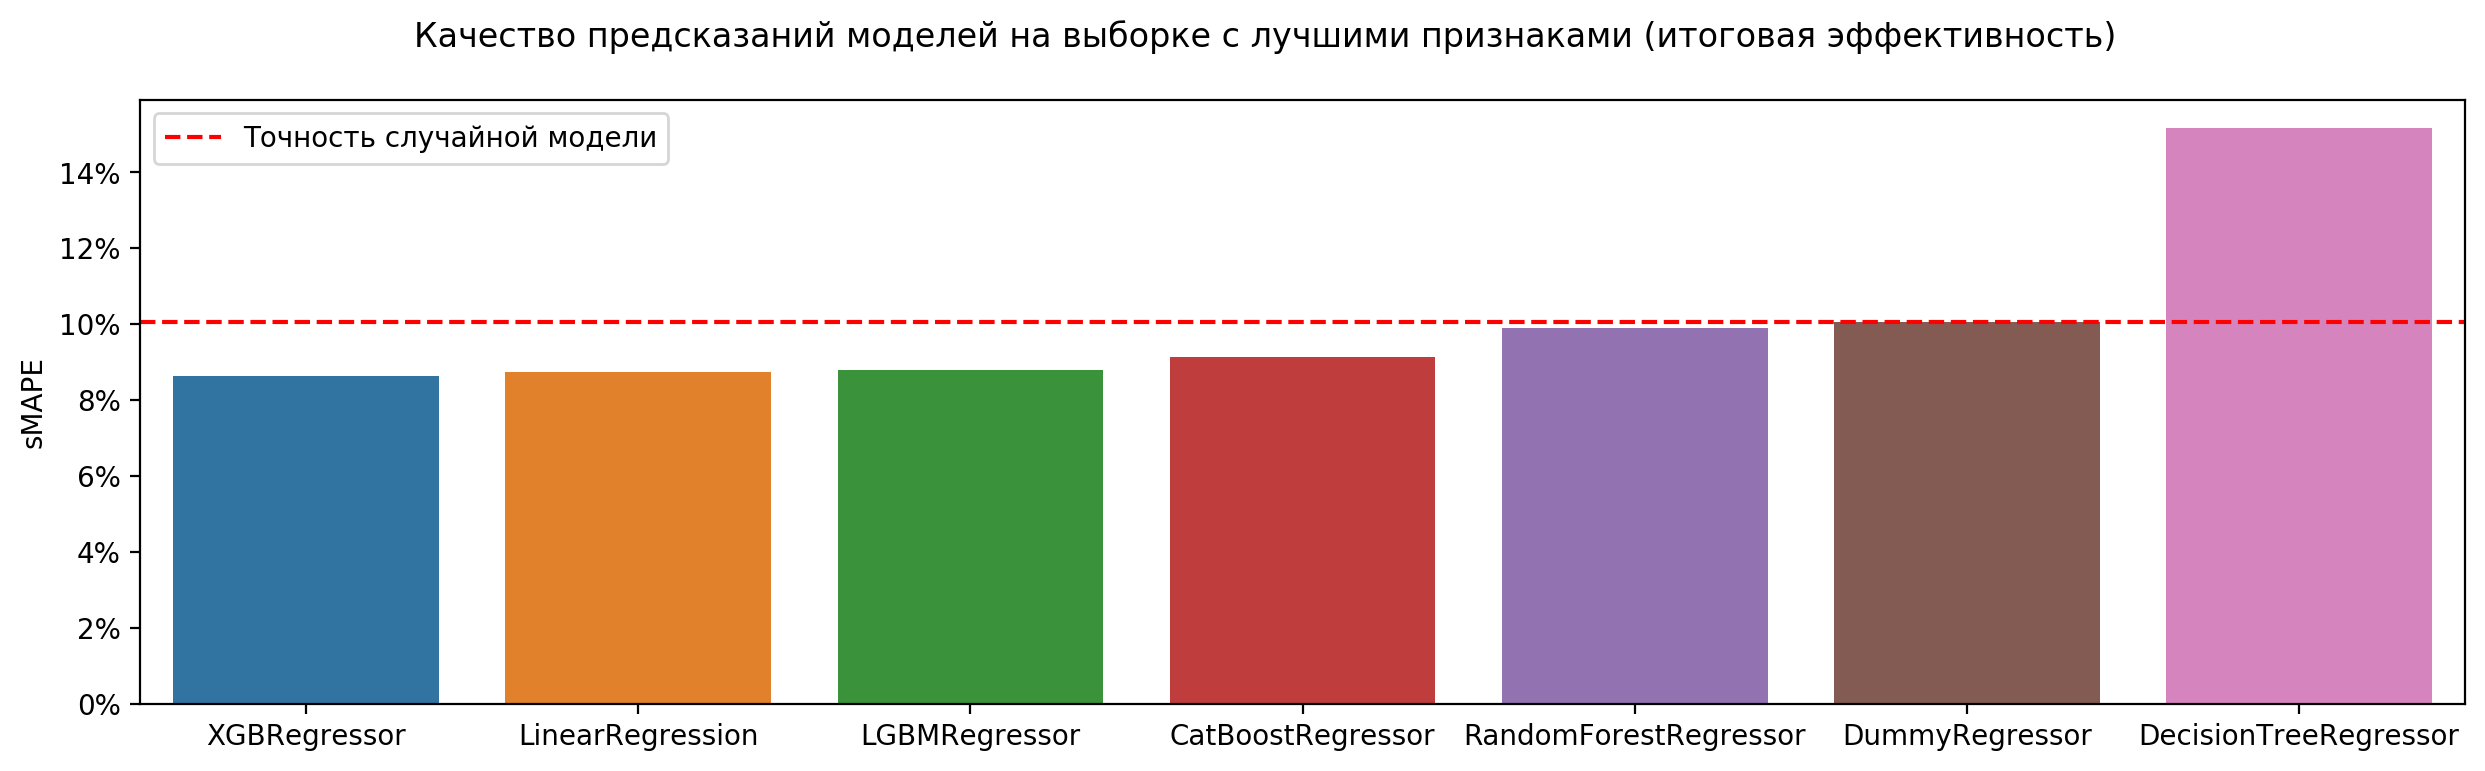

In [117]:
# Посмотрим на диаграмме
with Image(st='Качество предсказаний моделей на выборке с лучшими признаками (итоговая эффективность)', legend='a'):
    sns.barplot(final_base_features.index, final_base_features.no_primary_no_feed_size)
    plt.axhline(final_base_features.loc['DummyRegressor', 'all'], c='r', ls='--', label='Точность случайной модели')
    Image.format_axis(1)
    Image.labels(0, 'sMAPE')

В этот раз `XGBoost` отличился и показал лучшие результаты на выборке без данных о первичной обработке и размерах гранул сырья. Посмотрим, получится ли у нас выжать из него максимум?

In [118]:
# Обозначим лучший набор признаков
final_cols = final_cols_grid['no_primary_no_feed_size']

In [119]:
# Обучим модель
final_model = GridSearchCV(XGBRegressor(random_state=0, verbose=0, booster='gbtree', objective='reg:squarederror'),
                           {'max_depth': range(3, 5)})

In [120]:
final_model.fit(x_train[final_cols], y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbose=0, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(3, 5)}, pre_dispatch='2*n_jobs',
             refit=True, return_tra

In [121]:
# Сохраним предсказания
final_preds = final_model.predict(x_test[final_cols])

In [122]:
# Оценим качество на тестовой выборке
final_smape = smape(y_test, final_preds)
final_smape

0.07538742307719519

Тестовую выборку `XGBoost` предсказал даже лучше, чем тренировочную при кросс-валидации. Это нас очень обрадовало.

Как выглядит распределение ответов модели по сравнению с реальными ответами?

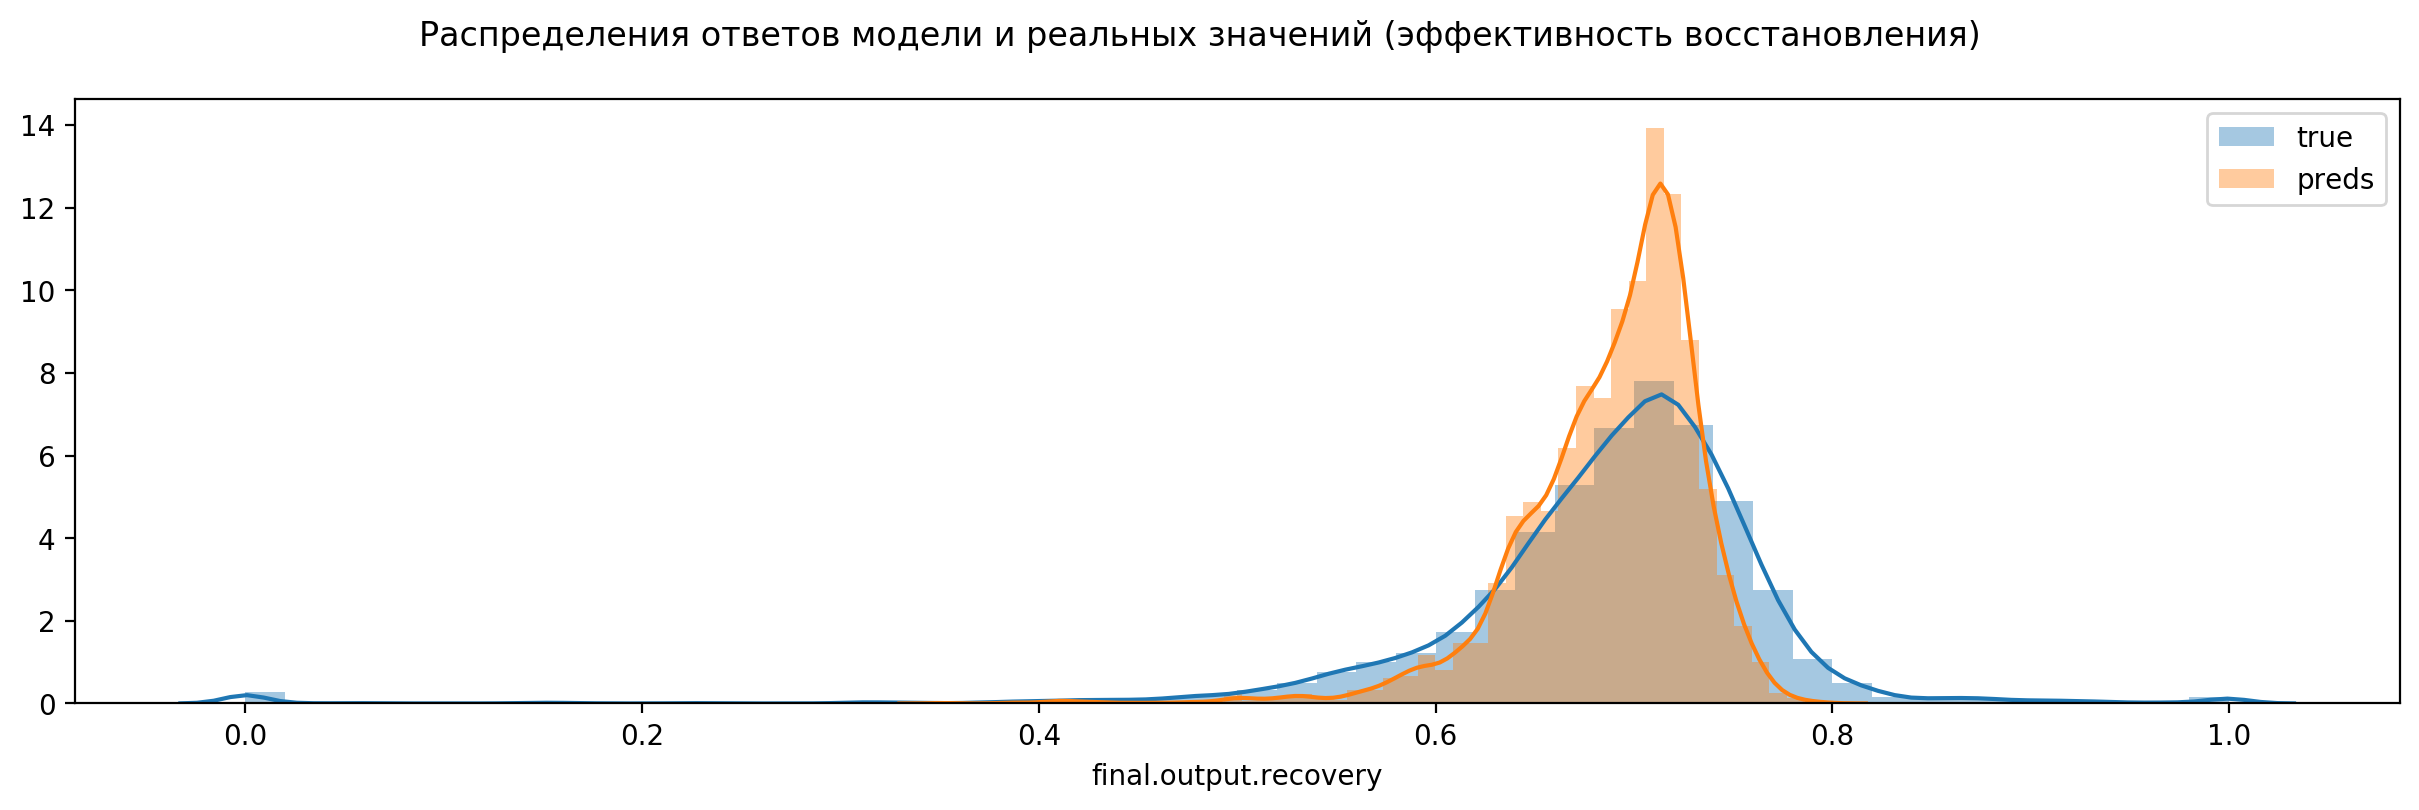

p-value = 1.222166197487155e-05
p-value < 0.05


In [123]:
dist_compare(y_test, final_preds, st='Распределения ответов модели и реальных значений (эффективность восстановления)')

### Вывод из обучения модели для предсказания качества восстановления золота
- Распределения выглядят аналогично распределениям ответов по флотации.
- *p-value* не позволяет сказать, что распределения схожи. Виною этому могут быть нулевые значения.
- И тоже аналогично предыдущей модели, мы можем выбирать оптимальные параметры всего технического процесса по предсказаниям, которые даёт модель.

---

### Подсчёт итоговой sMAPE
У нас есть оба значения sMAPE, и мы можем дать ответ на заключительный вопрос.

In [124]:
total_smape(float_smape, final_smape)

0.07984273971548156

У нас получилась средняя ошибка в *~8%*. Заодно убедимся, что это значение не хуже аналогичной оценки случайной модели.

In [125]:
total_smape(float_base_features.loc['DummyRegressor', :].mean(),
            final_base_features.loc['DummyRegressor', :].mean())

0.10386568924886115

- Не сильно, но наши старания дали sMAPE лучше, чем у случайной модели.
- Зато наши **модели можно использовать для нахождения оптимальных параметров процесса**, чего не скажешь о случайной.

---

## \* Поиск оптимальных параметров технологического процесса восстановления золота
Попробуем ради эксперимента выполнить Bootstrap из тестовой выборки: будем брать лучшие 50 предсказаний из 300 случайных наборов параметров и смотреть, какое среднее recovery из этого получается.

In [126]:
recoveries = []
rstate = np.random.RandomState(100)

# Присваиваем предсказаниям индексы
preds_series = pd.Series(final_preds, index=y_test.index)
for i in range(1000):
    #Выбираем 300 случайных наборов параметров
    choice = preds_series.sample(300, replace=True, random_state=rstate)
    # Оставляем 50 индексов с наибольшими значениями предсказаний
    indices = choice.sort_values(ascending=False).index[:50]
    # Берем среднее реальных значений по этим индексам
    recoveries.append(y_test[indices].mean())

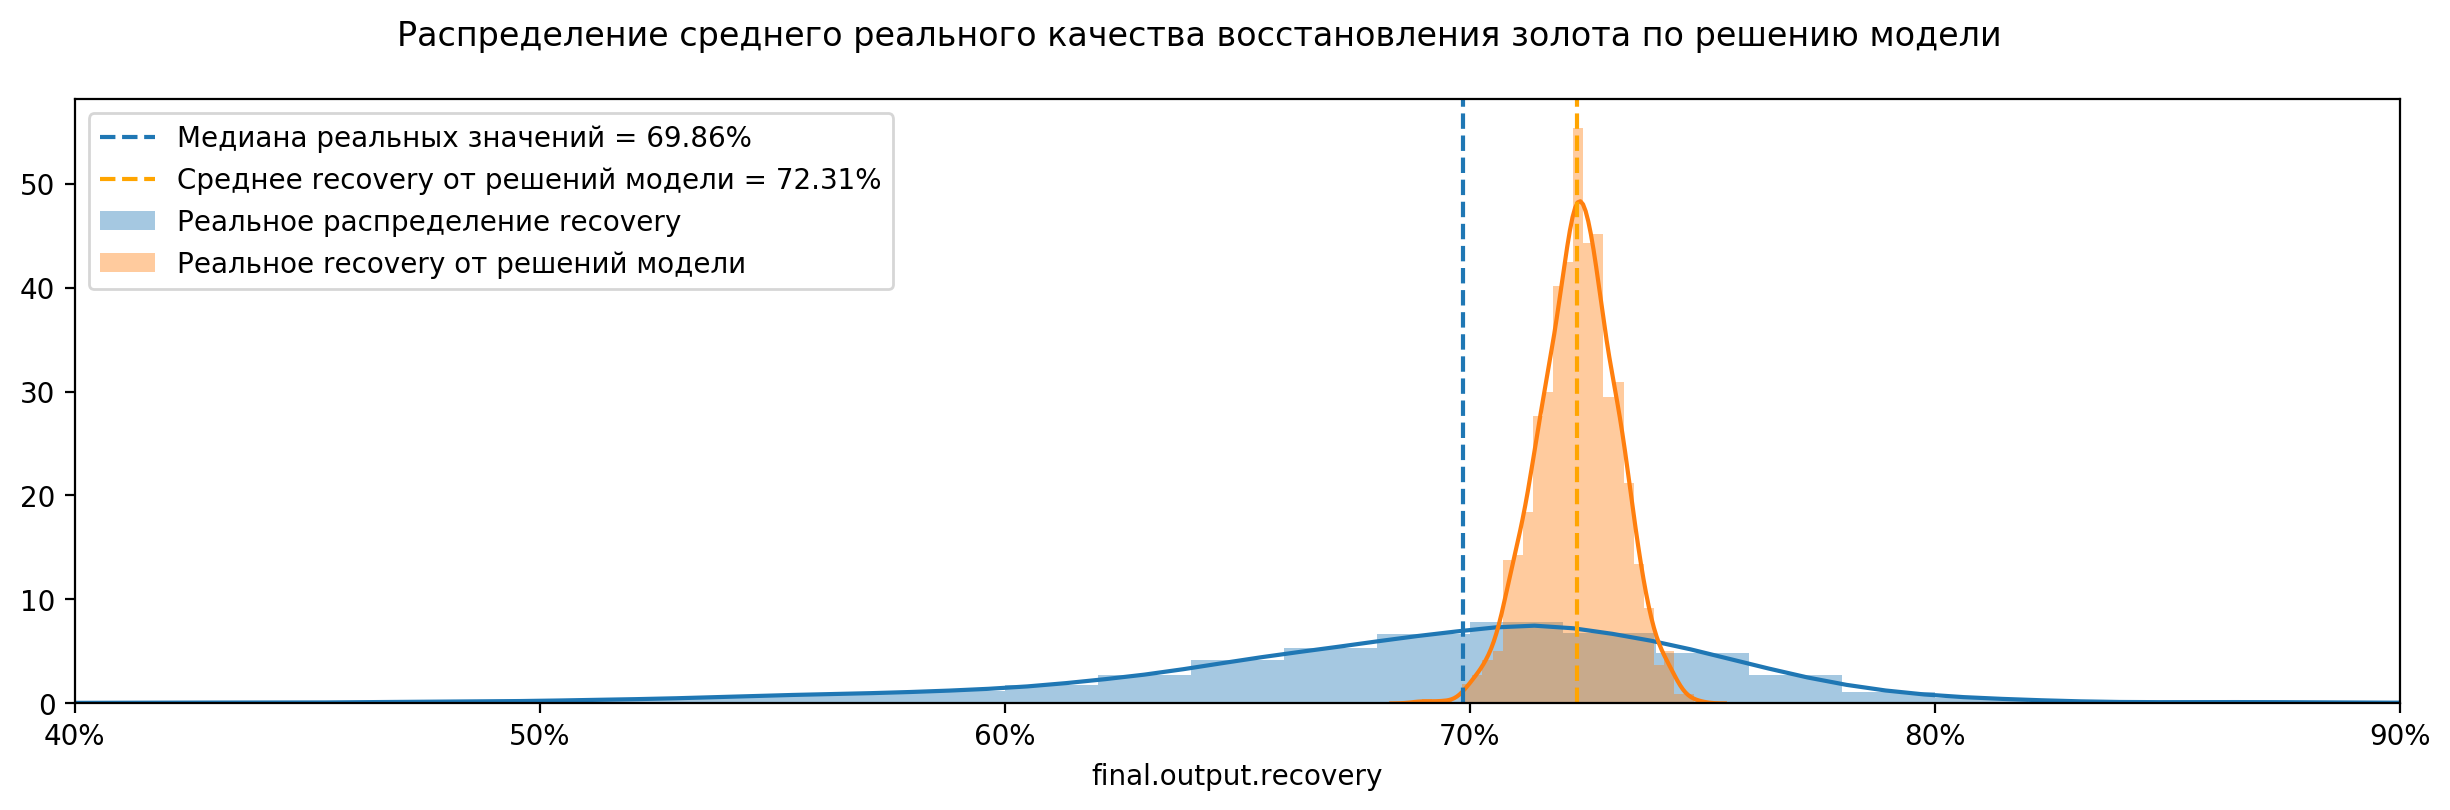

In [127]:
with Image(st='Распределение среднего реального качества восстановления золота по решению модели', legend='a'):
    sns.distplot(y_test, label='Реальное распределение recovery')
    sns.distplot(recoveries, label='Реальное recovery от решений модели')
    plt.axvline(y_test.median(), label=f'Медиана реальных значений = {y_test.median():.2%}', ls='--')
    plt.axvline(np.mean(recoveries), label=f'Среднее recovery от решений модели = {np.mean(recoveries):.2%}', ls='--', c='orange')
    plt.xlim((0.4, 0.9))
    Image.format_axis(0)

- Как мы видим, среднее качество восстановления золота, полученное с помощью модели, выше, чем медианное качество по всей выборке.

Чтобы получить уверенный результат, мы можем усреднить признаки-входные параметры, предложенные моделью как лучшие. Например:

In [128]:
# Recovery от признаков, выбранных моделью и усреднённых
optimizer_recoveries = []
rstate_opt = np.random.RandomState(46)

for i in range(1000):
    # Возьмём (не)случайный набор из 50 индексов лучших предсказаний
    optimizer_indices = preds_series.sample(300, replace=True, random_state=rstate_opt).sort_values(ascending=False)[:50].index
    
    # Усредним все предложенные моделью фичи
    optimized_features = data.reindex(optimizer_indices).mean()
    
    # Посчитаем recovery по формуле и добавим в распределение
    optimizer_recoveries.append(
        pd.DataFrame(optimized_features).apply(final_recovery))

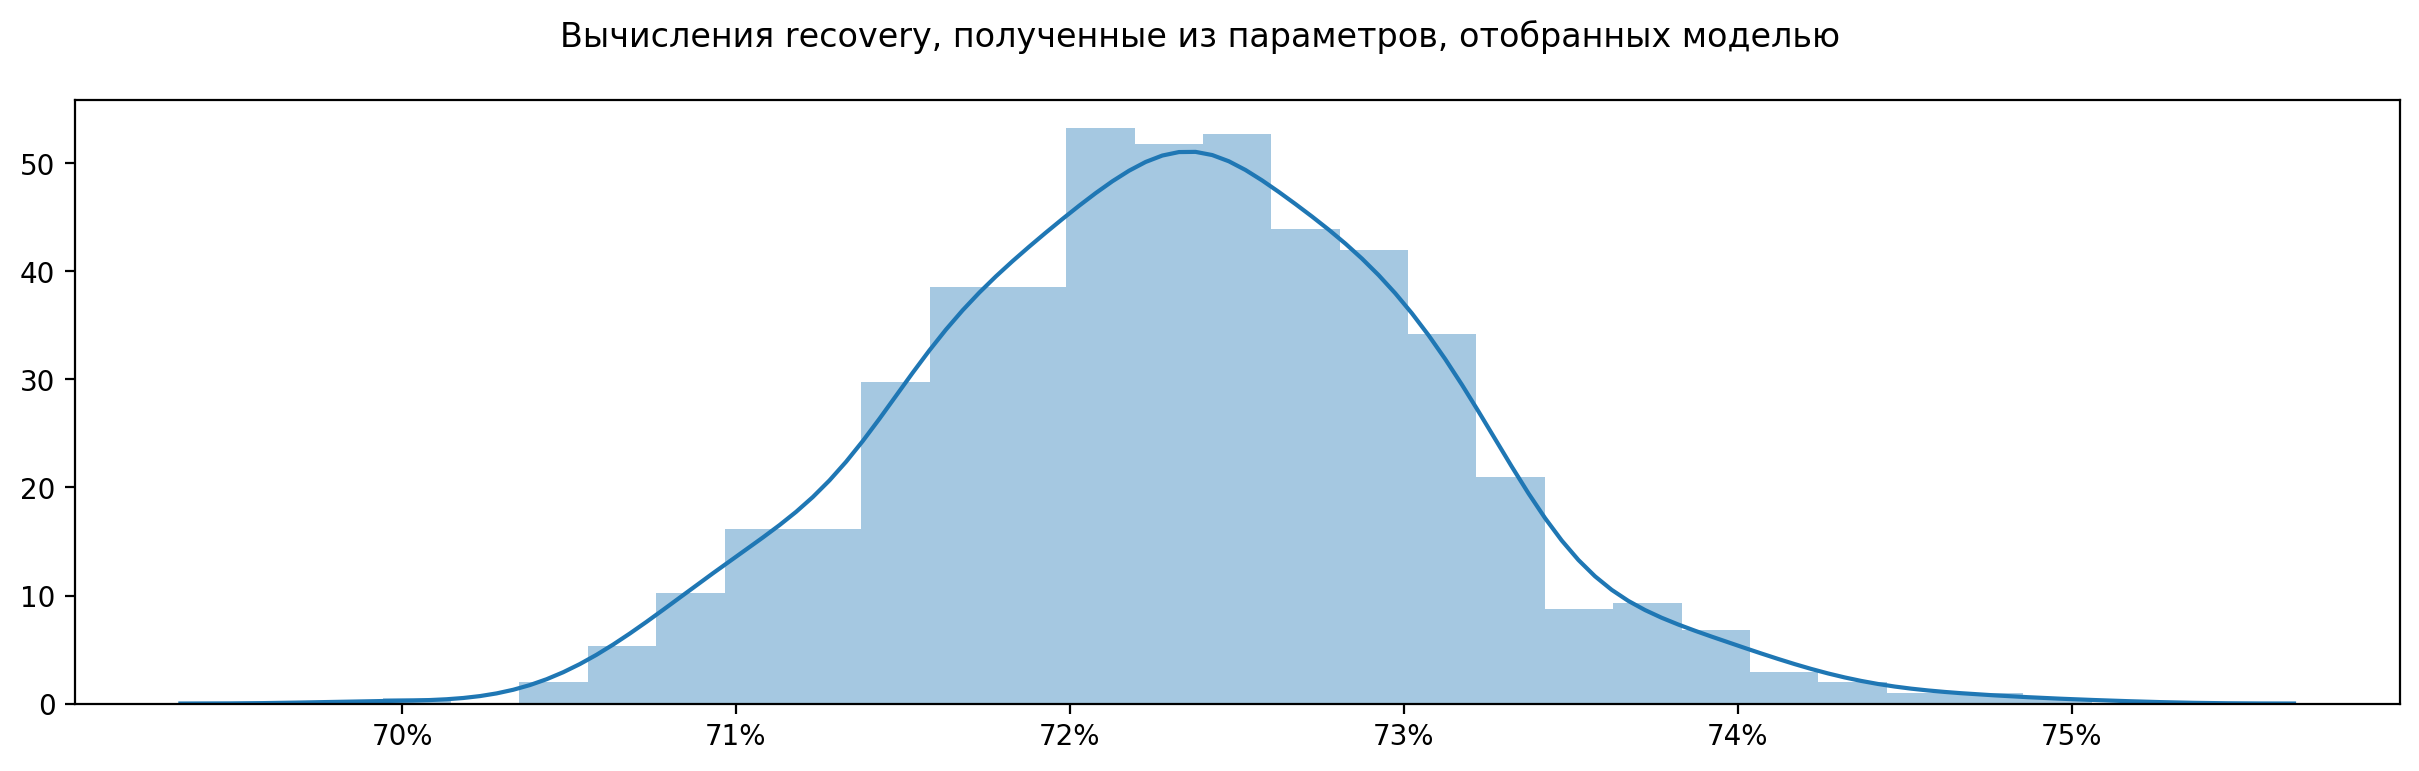

In [129]:
with Image(st='Вычисления recovery, полученные из параметров, отобранных моделью'):
    sns.distplot(optimizer_recoveries)
    Image.format_axis(0)

Вот мы и научились находить оптимальный рецепт восстановления золота, извлекая его из ответов модели.

Так могут выглядеть оптимальные параметры технологического процесса, выбранные лучшими по мнению модели и усреднённые для защиты от выбросов.

In [130]:
optimized_features

final.output.concentrate_ag                     5.855372
final.output.concentrate_pb                     9.877680
final.output.concentrate_sol                   10.485609
final.output.concentrate_au                    44.698893
final.output.recovery                           0.719033
                                                 ...    
secondary_cleaner.state.floatbank6_a_air       15.559046
secondary_cleaner.state.floatbank6_a_level   -488.031422
raw_input                                     110.876342
rougher_concentrate                            72.667872
final_concentrate                              70.917554
Length: 89, dtype: float64

---

# Общий вывод
Нашей целью было подготовить модель, которая помогла бы оптимизировать процесс восстановления золота из руды. *Как мы это сделали?*
- **Предобработка**:
    - Мы выполнили предобработку имеющихся у нас данных и исправили ошибки, допущенные при создании обучающей и тестовой выборок. Очистили данные от строк, содержащих пропуски.
    - Проверили, насколько показания recovery в наблюдениях правильно посчитаны. Исправили ошибку с масштабом.
- **Исследовательский анализ**:
    - Проанализировали то, как меняются концентрации металлов в ходе технологического процесса. Предположили, что этап первичной очистки не так важен для модели, потому что увидели линейные изменения концентраций.
    - Обнаружили, что распределения размеров гранул сырья в тестовой и обучающей выборках различается. Приняли решение не использовать этот признак при обучении.
    - Нашли аномальные значения в суммарной концентрации веществ в некоторых наблюдениях. Удалили эти наблюдения как выбросы.
- **Обучение модели**:
    - Обучили две модели, предсказывающие качество флотации и всего технологического процесса по входным параметрам. Для этого мы провели соревнование большого количества моделей с разными фичами.
    - Посчитали итоговый sMAPE моделей.
- **Поиск оптимальных параметров технологического процесса**:
    - Провели два эксперимента техникой бутстреп:
        - Позволили модели выбрать лучшие параметры процесса и нашли распределение реальных значений по решению модели. Модель позволяет получить стабильно хорошее recovery: лучше, чем среднее реальных значений в тестовой выборке.
        - Дали модели выбрать лучшие параметры процесса, усреднили эти параметры и высчитали для них recovery по формуле. Распределение recovery получилось похожим на первый случай.
    - Важно заметить, что мы смогли предложить приблизительные параметры технологического процесса, дающие уверенный результат с большой вероятностью. Для этого мы и выполнили наш проект.

---